In [387]:
# import libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import cross_val_predict, KFold
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# import performance metrics/measures
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, classification_report




In [388]:
# Read csv dataset and display first 5 records
rawdata = pd.read_csv('UCI_Credit_Card.csv',sep= ',')
rawdata.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [389]:
#print information about the dataset including index, dtype,number of rows and columns, non-null values
rawdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [390]:
# Total 30000 clients in dataset from 0 to 29999
# Total 25 data columns
# There are no missing data in the dataset.
# "default.payment.next.month" is a feature and is the target variable

In [391]:
#Data pre-processing of PAY_n attributes :
# since PAY_n can take as values only -1,1,2,3,4,5,6,7,8,9 as per the data dictionary - 
# convert -2,-1 values to -1. 
# Increment each pay value >=0 by 1 number  
for att in ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
  # categories -2,-1 are grouped into a single class -1: pay duty   
  filter = (rawdata[att] == -2) | (rawdata[att] == -1) 
  rawdata.loc[filter, att] = -1
  # print(data[att].unique())
  # moreover the category 0 is undocumented
  # so each category >= 0 has been updated by adding 1
  rawdata[att] = rawdata[att].astype('int64')
  filter = (rawdata[att] >= 0)
  rawdata.loc[filter, att] = rawdata.loc[filter, att] + 1

In [392]:
# Data pre-processing :
# convert categorical data (Sex, Education, Marriage, Pay_n attributes) to categorical data type
rawdata['SEX']=rawdata['SEX'].astype('category')
rawdata['EDUCATION']=rawdata['EDUCATION'].astype('category')
rawdata['MARRIAGE']=rawdata['MARRIAGE'].astype('category')
rawdata['PAY_0']=rawdata['PAY_0'].astype('category')
rawdata['PAY_2']=rawdata['PAY_2'].astype('category')
rawdata['PAY_3']=rawdata['PAY_3'].astype('category')
rawdata['PAY_4']=rawdata['PAY_4'].astype('category')
rawdata['PAY_5']=rawdata['PAY_5'].astype('category')
rawdata['PAY_6']=rawdata['PAY_6'].astype('category')
rawdata['default.payment.next.month']=rawdata['default.payment.next.month'].astype('category')

# drop first attribute "ID"
rawdata.drop('ID', axis = 1, inplace =True)

# Education attribute - grouping 0, 5 and 6 categories to one group ie., unknown (4)
rawdata['EDUCATION'].replace({0:4,5:4,6:4},inplace=True)

# Marriage attribute - grouping 0 category to unknown (3)
rawdata['MARRIAGE'].replace({0:3},inplace=True)

#rename "default.payment.next.month", "PAY_0"
rawdata.rename(columns={"default.payment.next.month" : "DEFAULT", "PAY_0": "PAY_1"},inplace=True)


In [393]:
#check for missing values
rawdata.isnull().values.any()

False

In [394]:
#Is the dataset balanced ? there are 6636 defaults in the dataset of total 30000 clients
rawdata['DEFAULT'].value_counts()

DEFAULT
0    23364
1     6636
Name: count, dtype: int64

In [395]:
# select only the numeric attributes from the raw dataset
numeric_attributes = ['LIMIT_BAL','AGE','BILL_AMT1','BILL_AMT2','BILL_AMT3',
'BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3',
'PAY_AMT4','PAY_AMT5','PAY_AMT6']
  
#calculate the 5 number summary
rawdata[numeric_attributes].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
BILL_AMT1,30000.0,51223.330900,73635.860576,-165580.0,3558.75,22381.5,67091.00,964511.0
BILL_AMT2,30000.0,49179.075167,71173.768783,-69777.0,2984.75,21200.0,64006.25,983931.0
BILL_AMT3,30000.0,47013.154800,69349.387427,-157264.0,2666.25,20088.5,60164.75,1664089.0
BILL_AMT4,30000.0,43262.948967,64332.856134,-170000.0,2326.75,19052.0,54506.00,891586.0
BILL_AMT5,30000.0,40311.400967,60797.155770,-81334.0,1763.00,18104.5,50190.50,927171.0
BILL_AMT6,30000.0,38871.760400,59554.107537,-339603.0,1256.00,17071.0,49198.25,961664.0
PAY_AMT1,30000.0,5663.580500,16563.280354,0.0,1000.00,2100.0,5006.00,873552.0
PAY_AMT2,30000.0,5921.163500,23040.870402,0.0,833.00,2009.0,5000.00,1684259.0


In [396]:
# Univariate Analysis of categorical variables :

categorical_attributes = ['SEX','EDUCATION','MARRIAGE','PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']

for var in categorical_attributes:
    print(f"Variable: {var}")
    print(rawdata[var].value_counts())
    print()

Variable: SEX
SEX
2    18112
1    11888
Name: count, dtype: int64

Variable: EDUCATION
EDUCATION
2    14030
1    10585
3     4917
4      468
Name: count, dtype: int64

Variable: MARRIAGE
MARRIAGE
2    15964
1    13659
3      377
Name: count, dtype: int64

Variable: PAY_1
PAY_1
1     14737
-1     8445
2      3688
3      2667
4       322
5        76
6        26
9        19
7        11
8         9
Name: count, dtype: int64

Variable: PAY_2
PAY_2
1     15730
-1     9832
3      3927
4       326
5        99
2        28
6        25
8        20
7        12
9         1
Name: count, dtype: int64

Variable: PAY_3
PAY_3
1     15764
-1    10023
3      3819
4       240
5        76
8        27
7        23
6        21
2         4
9         3
Name: count, dtype: int64

Variable: PAY_4
PAY_4
1     16455
-1    10035
3      3159
4       180
5        69
8        58
6        35
7         5
2         2
9         2
Name: count, dtype: int64

Variable: PAY_5
PAY_5
1     16947
-1    10085
3      2626
4       17

<Axes: xlabel='EDUCATION'>

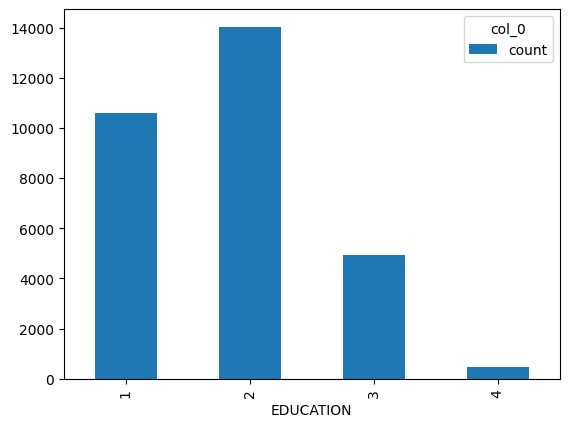

In [397]:
# Visualization plots of categorical variables :
# 1:'GraduateSchool',2:'University',3:'HighSchool',4:'Other'
my_tab = pd.crosstab(index=rawdata["EDUCATION"],columns="count")
my_tab.plot.bar()

<Axes: xlabel='SEX'>

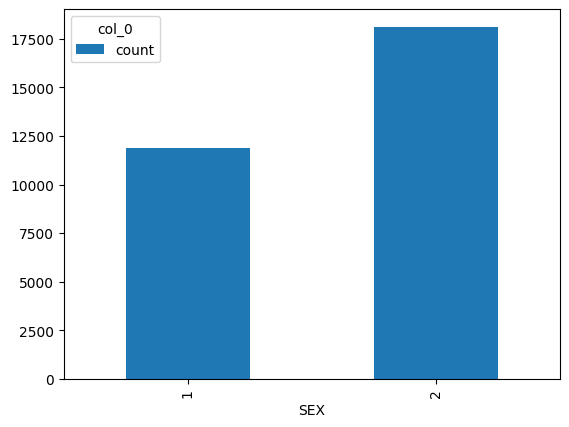

In [398]:
# 1:'Female',2:'Male'
my_tab = pd.crosstab(index=rawdata["SEX"],columns="count")
my_tab.plot.bar()

<Axes: xlabel='MARRIAGE'>

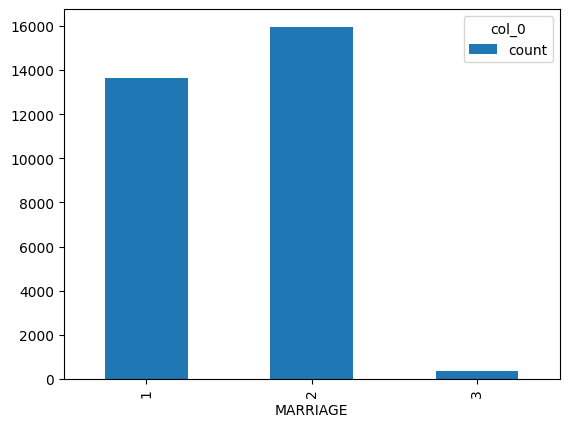

In [399]:
#1: 'Married', 2:'Single', 3:'Others'
my_tab = pd.crosstab(index=rawdata["MARRIAGE"],columns="count")
my_tab.plot.bar()

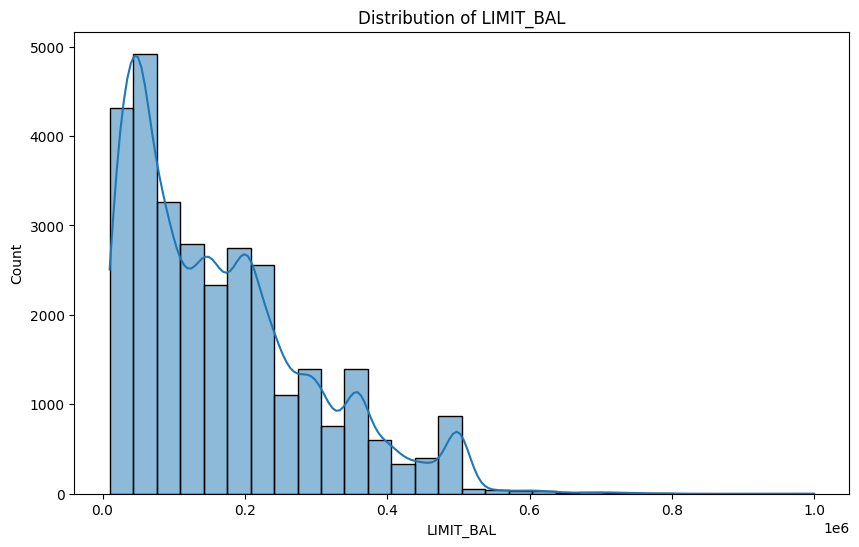

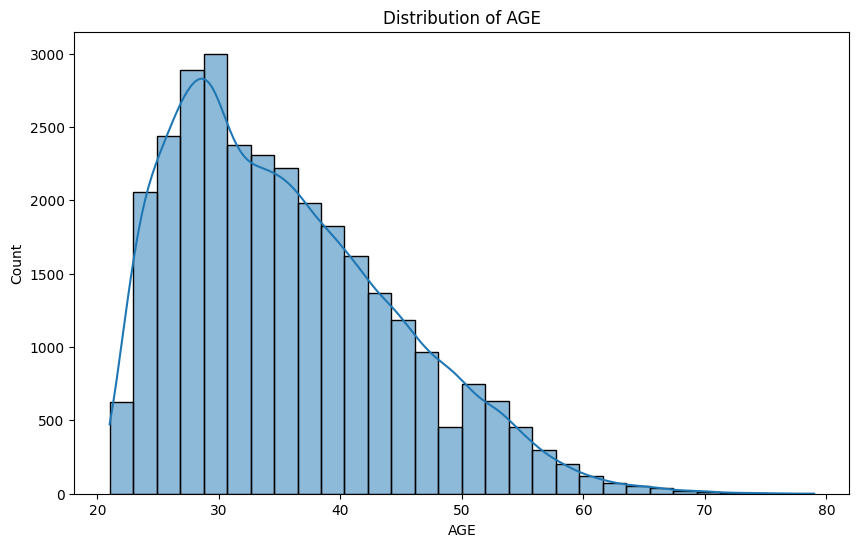

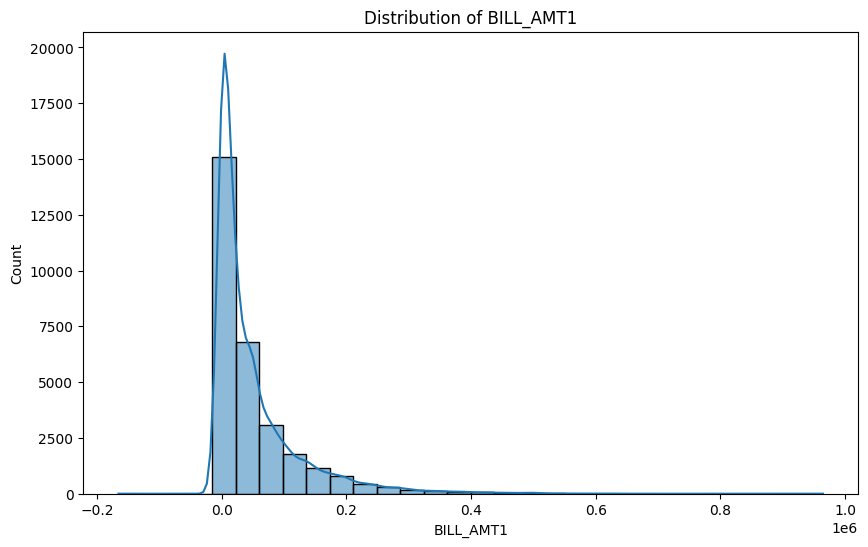

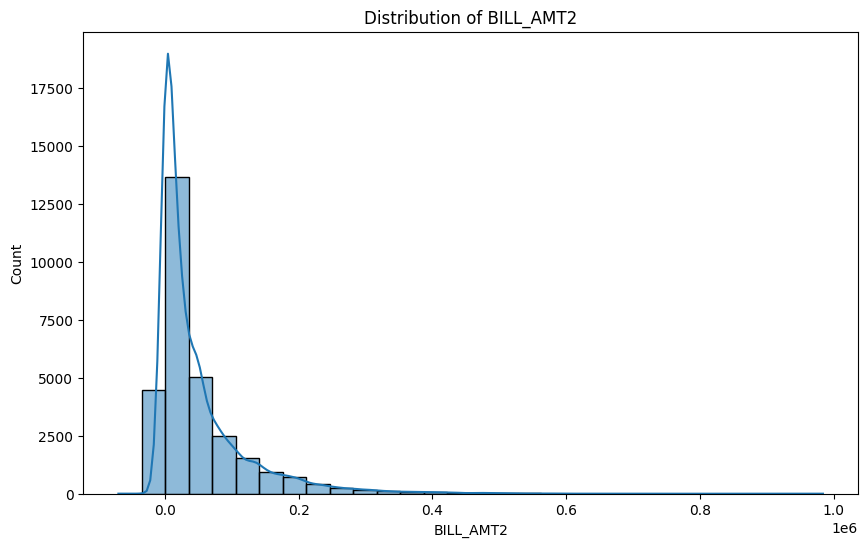

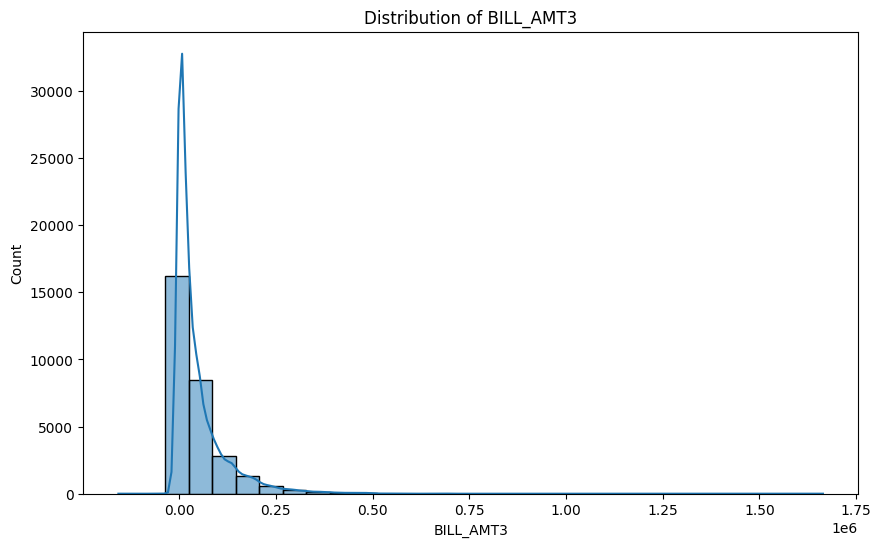

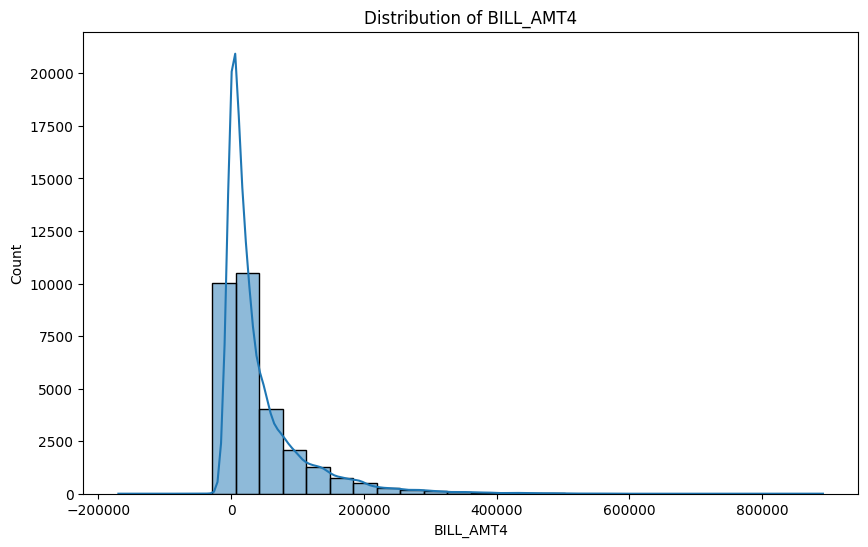

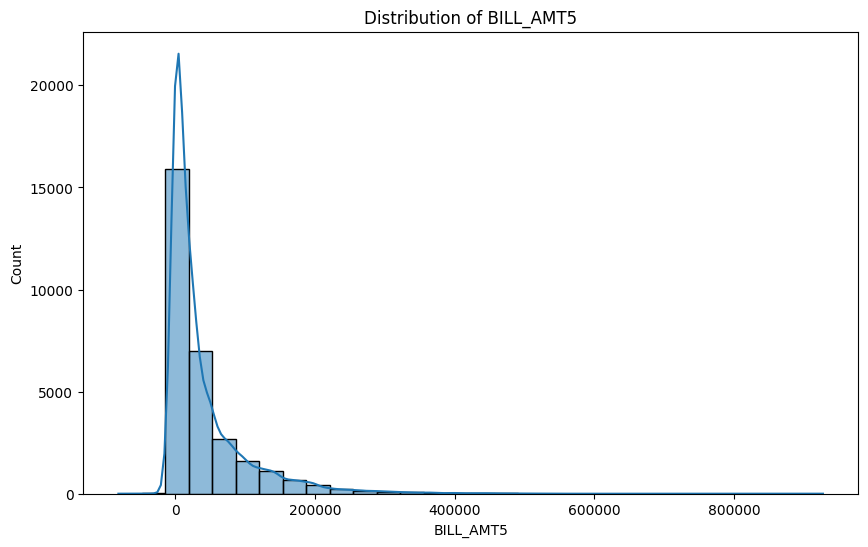

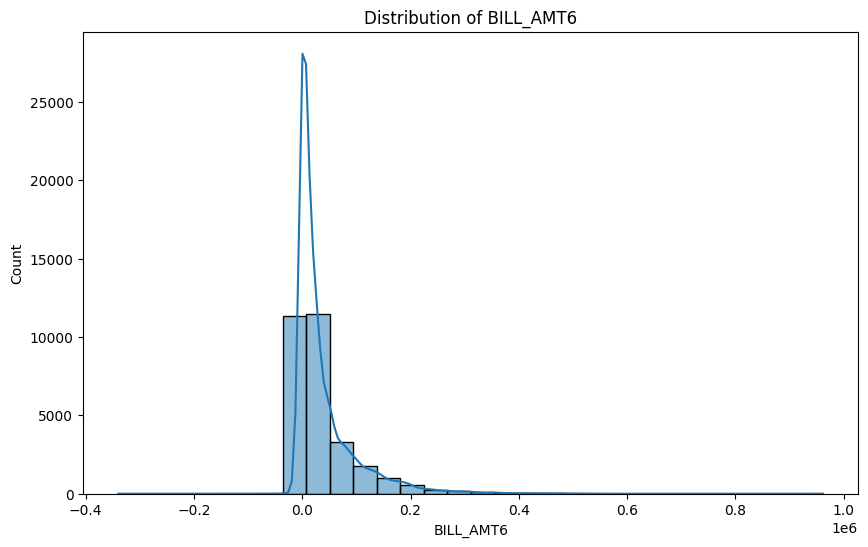

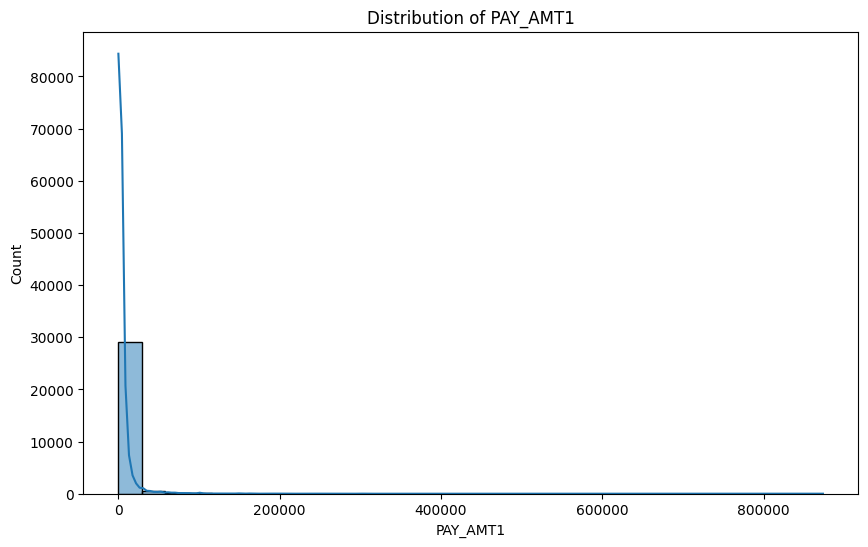

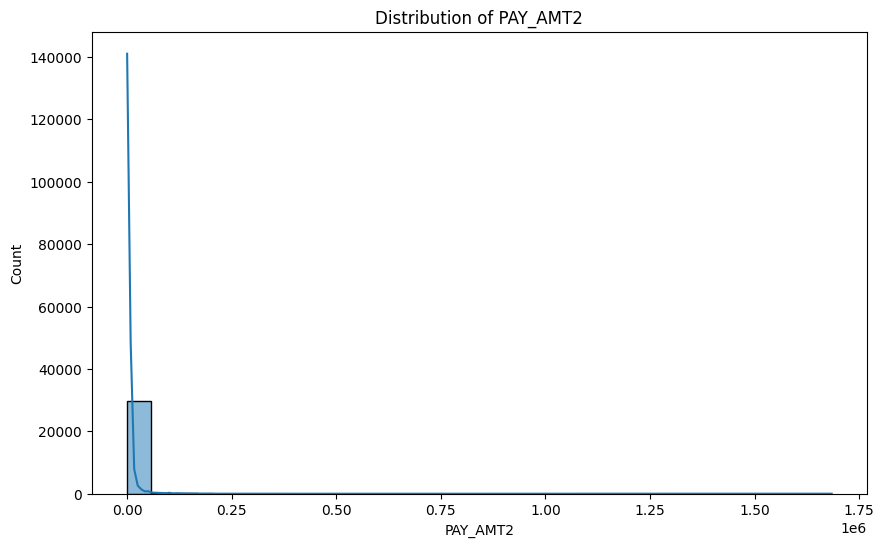

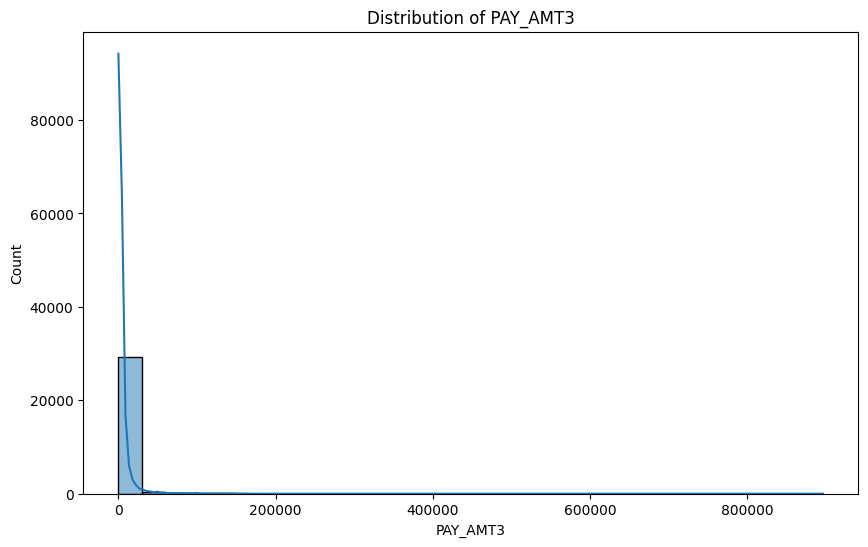

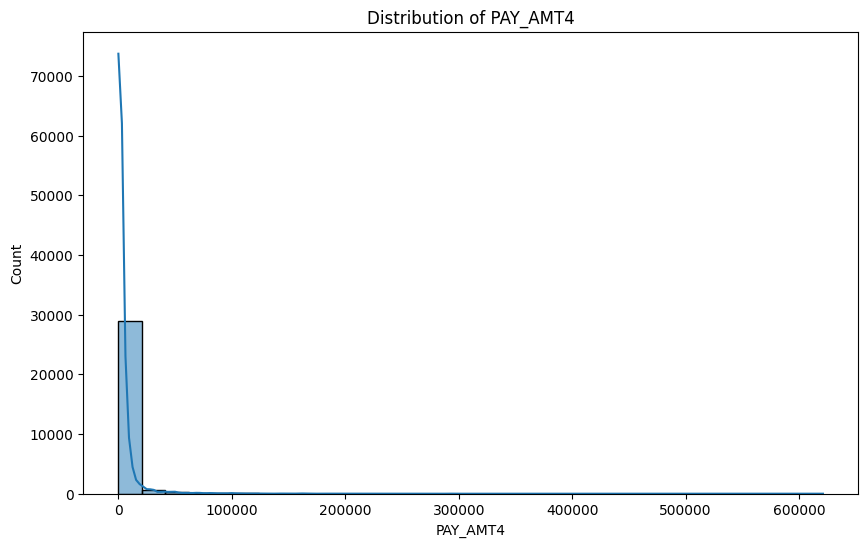

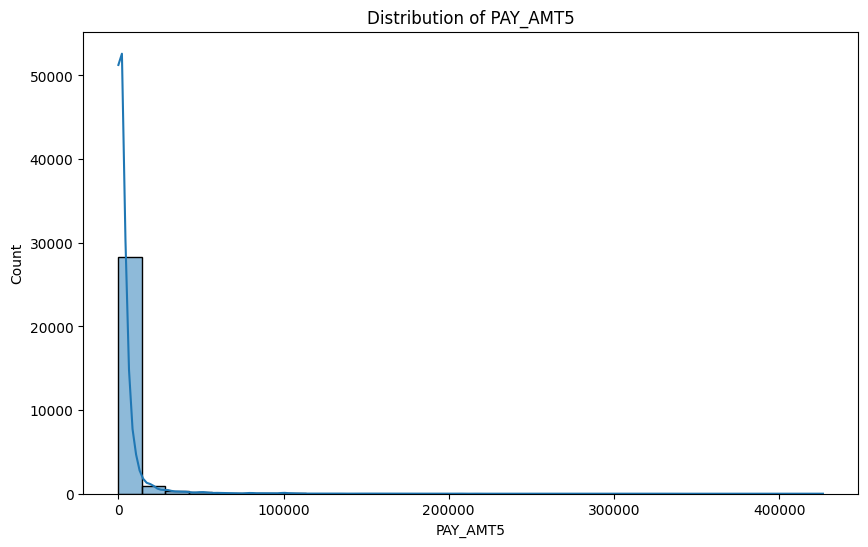

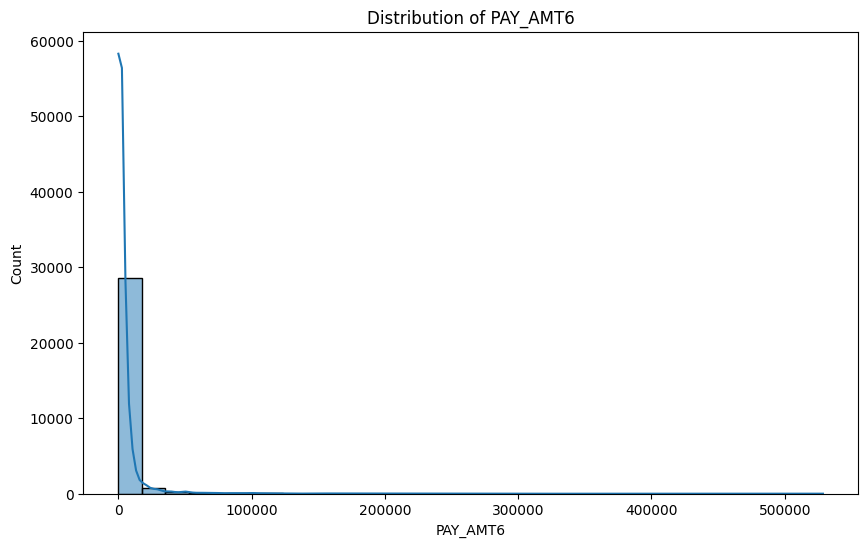

In [400]:
#rawdata['LIMIT_BAL'].describe()
for col in numeric_attributes:
    plt.figure(figsize=(10,6))
    sns.histplot(rawdata[col], bins=30, kde=True)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title(f"Distribution of {col}")
    plt.show()

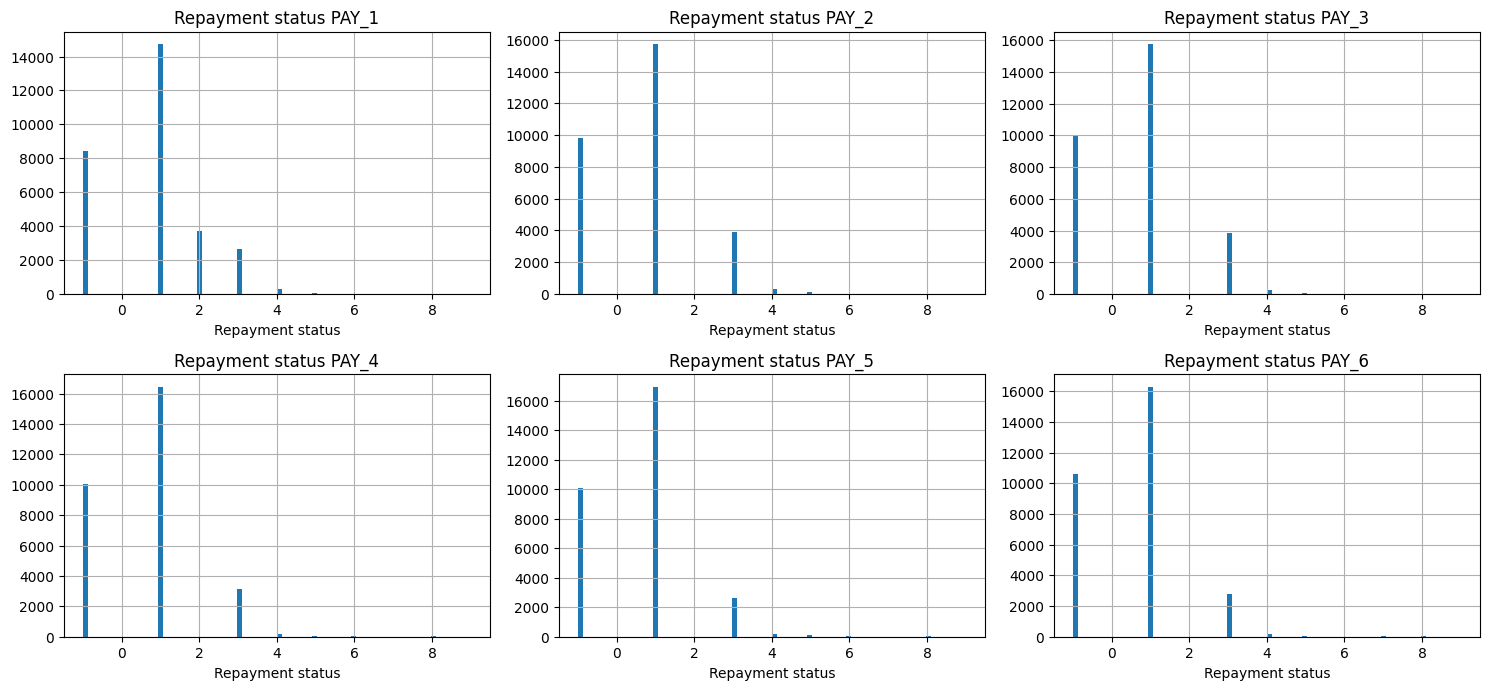

In [401]:
# List of PAY column names
pay_cols_names = ["PAY_1", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]

# Create a DataFrame with raw data
raw_data = pd.DataFrame({
    "PAY_0": [2, 0, 1, 2, 0, 0],
    # Include other PAY columns
    # ...
})

# Generate bar plots for PAY_0..6 variables
fig, axes = plt.subplots(len(pay_cols_names) // 3 + 1, 3, figsize=(15, 10))
for i, pay_col_name in enumerate(pay_cols_names):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    ax.hist(rawdata[pay_col_name], bins='auto')
    ax.set_title(f"Repayment status {pay_col_name}")
    ax.set_xlabel("Repayment status")
    ax.grid(True)

# Remove any empty subplots
for i in range(len(pay_cols_names), len(axes.flatten())):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


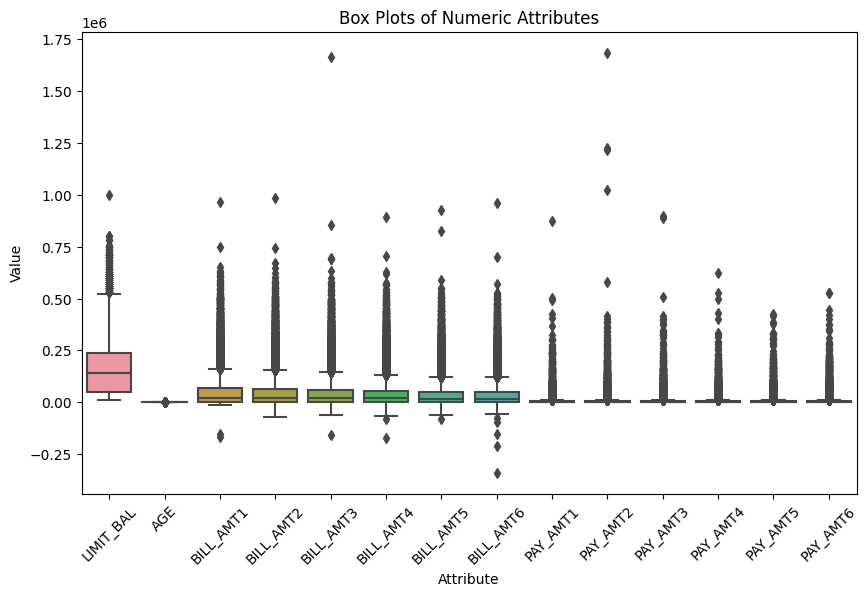

In [402]:
# Univariate analysis of numeric_attributes using boxplots:

plt.figure(figsize=(10,6))
sns.boxplot(data= rawdata[numeric_attributes])
plt.title('Box Plots of Numeric Attributes')
plt.xlabel('Attribute')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.show()

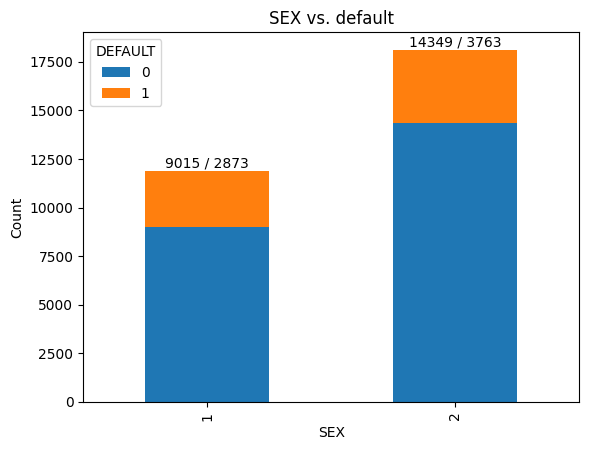

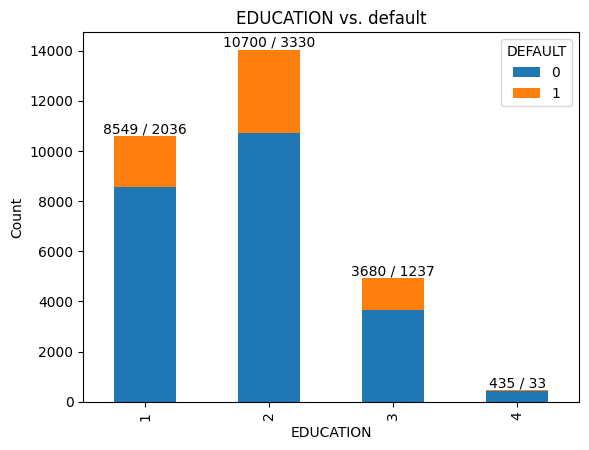

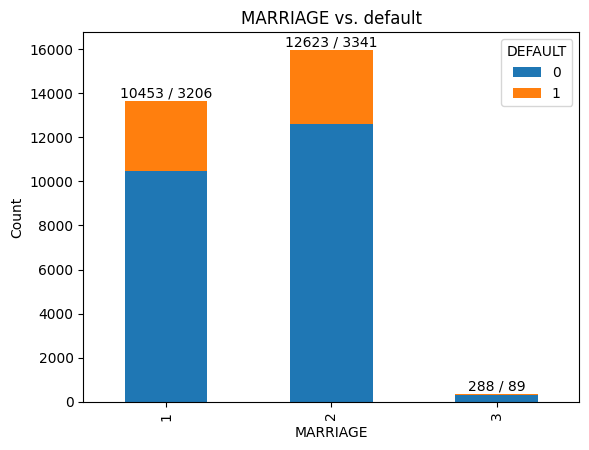

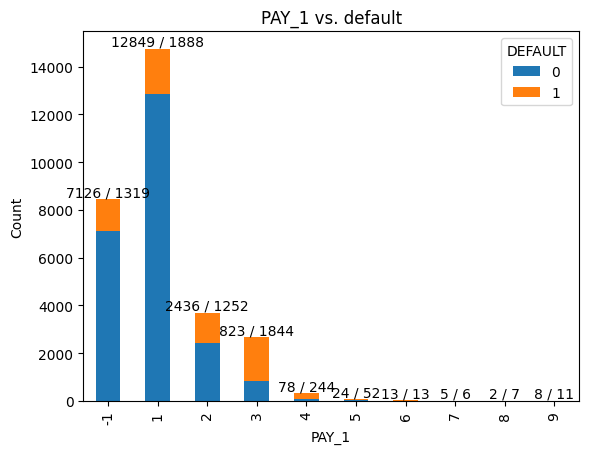

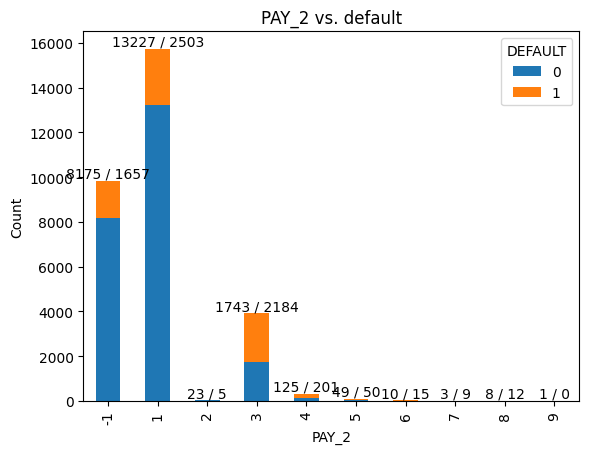

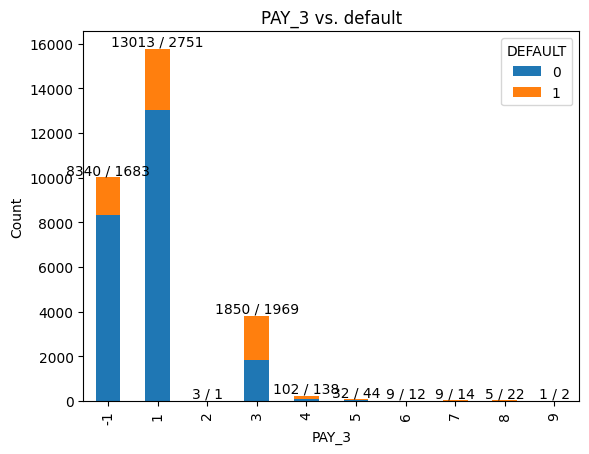

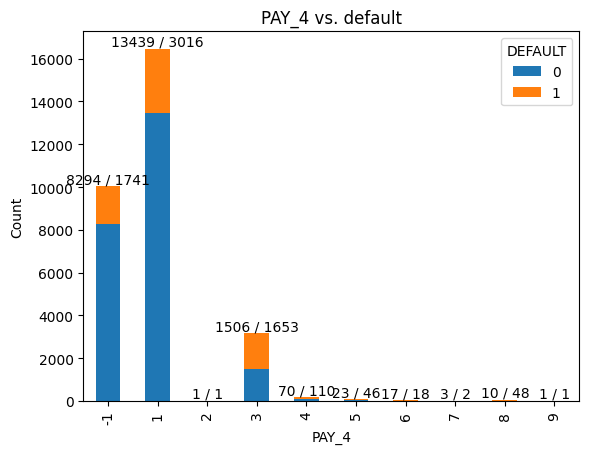

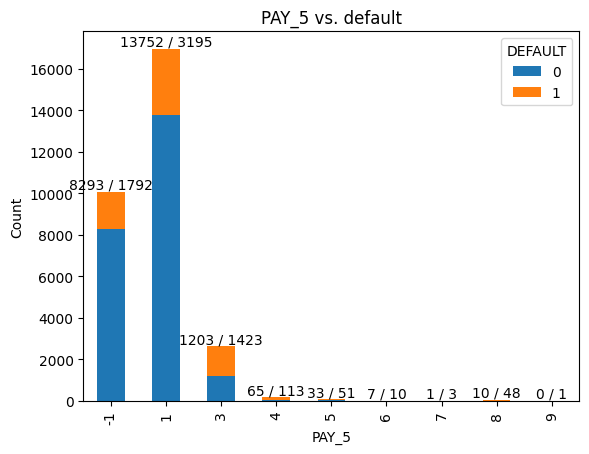

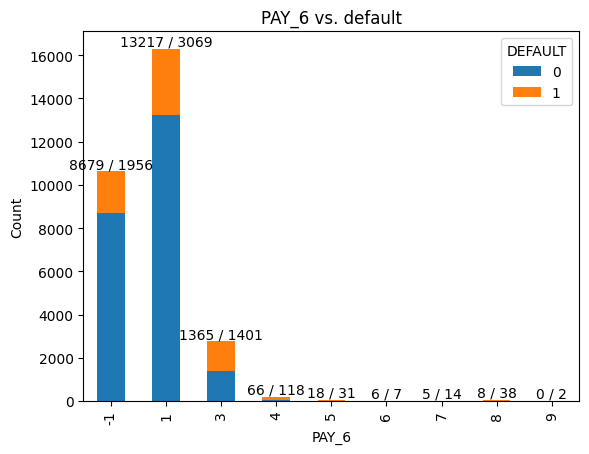

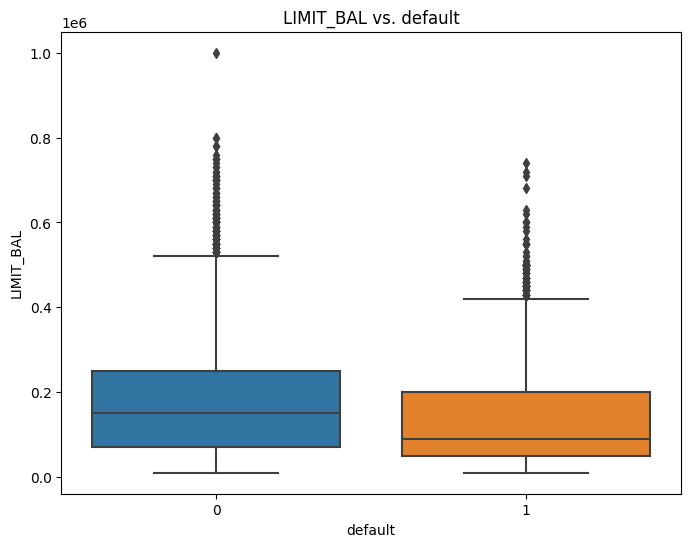

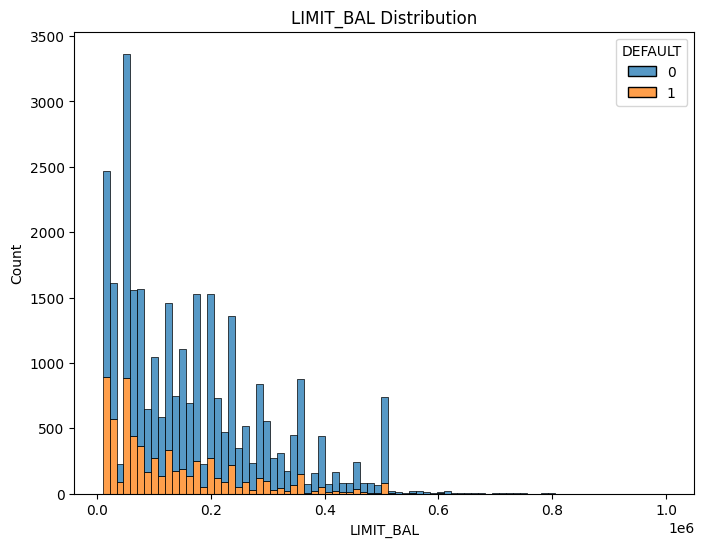

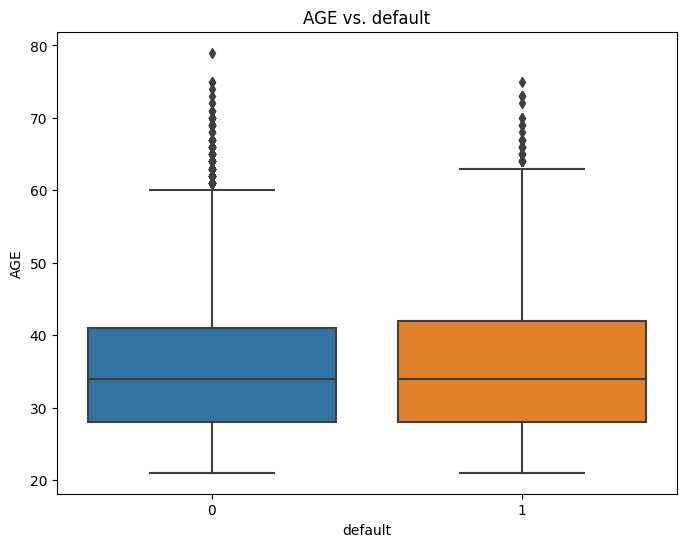

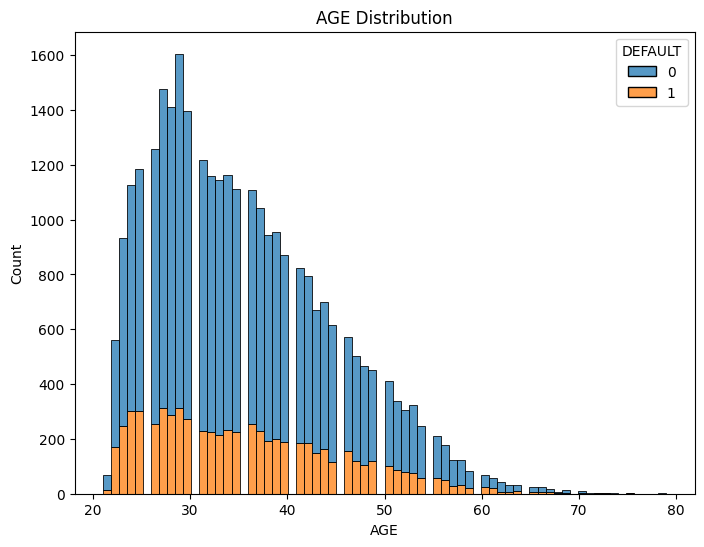

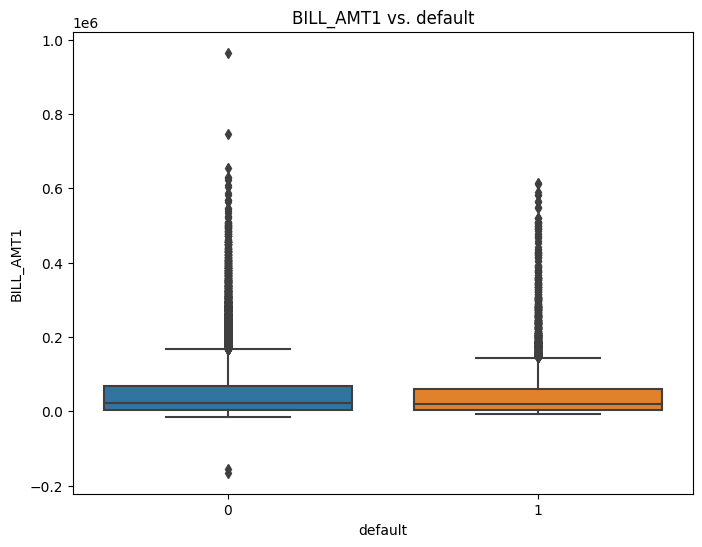

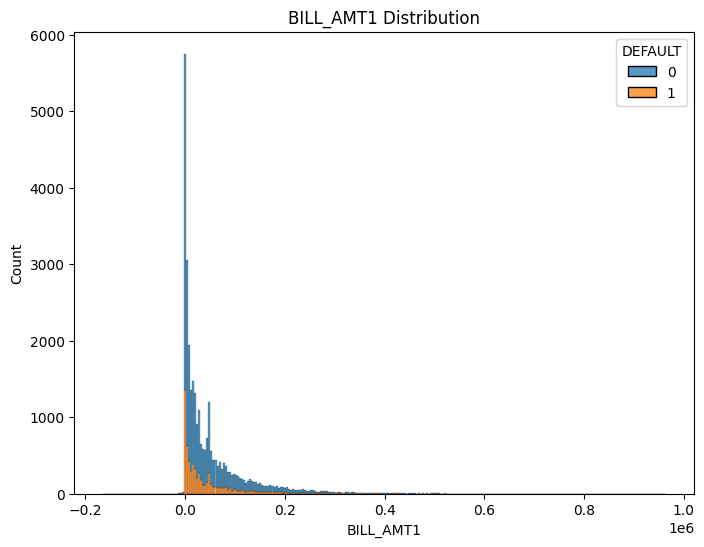

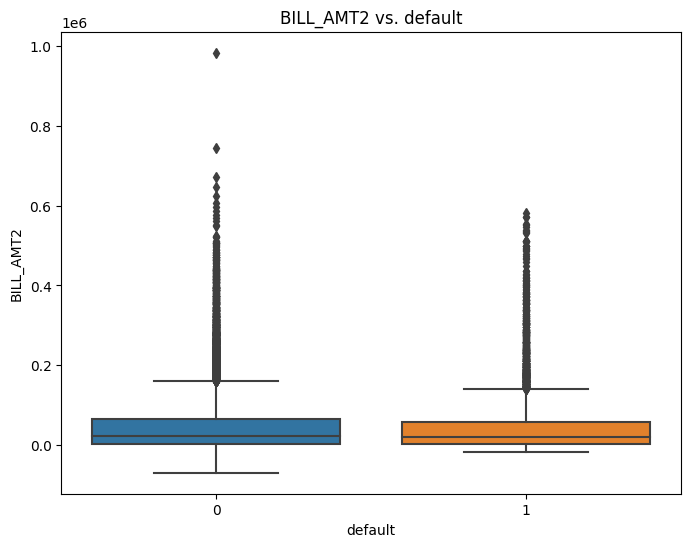

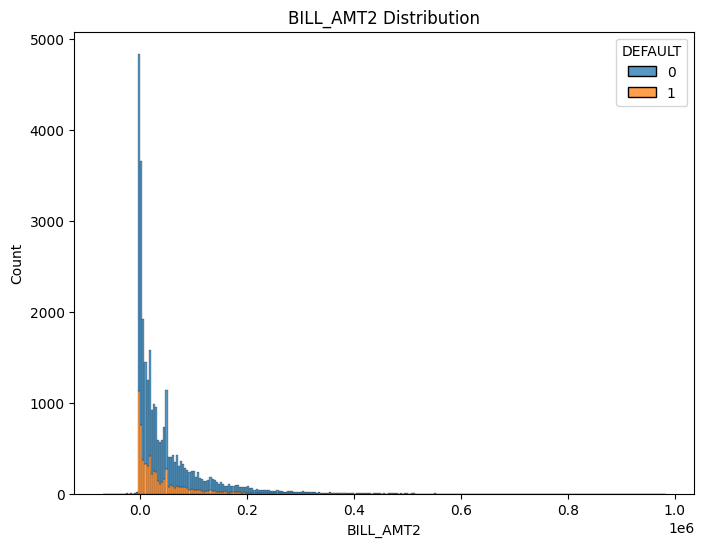

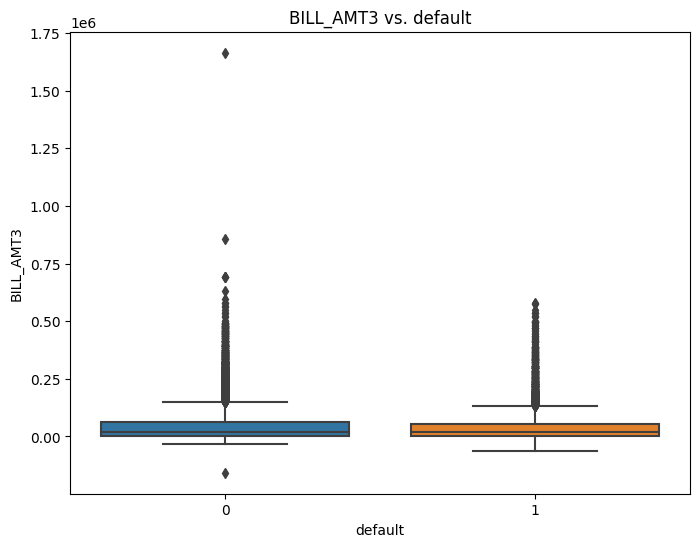

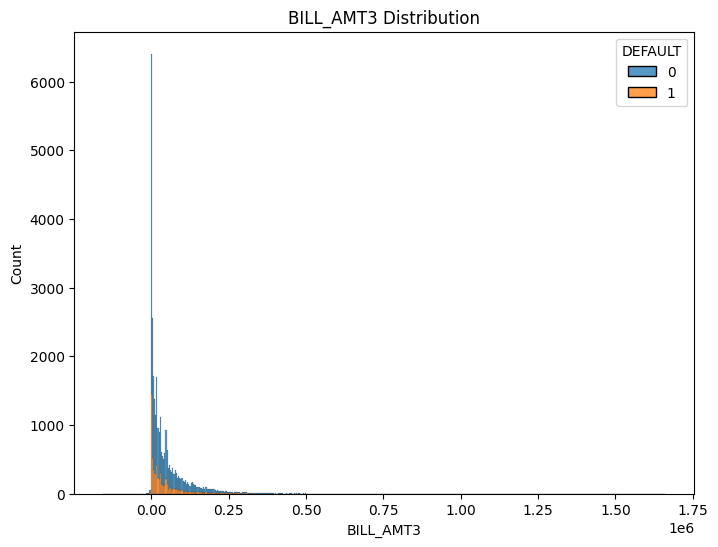

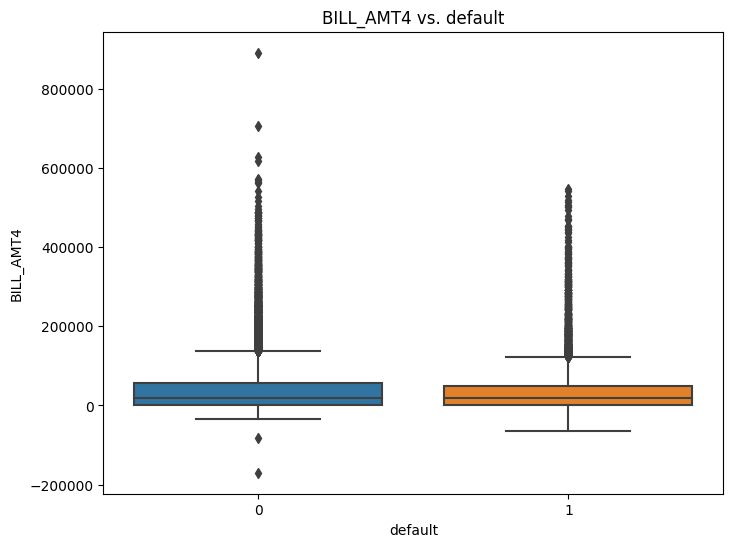

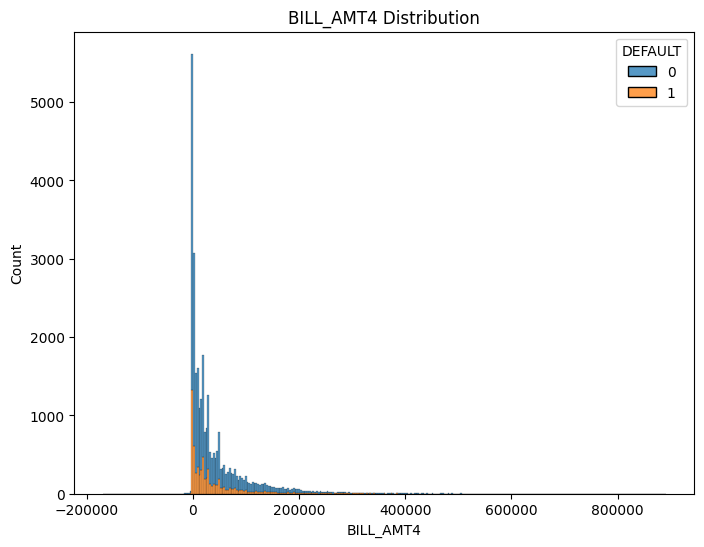

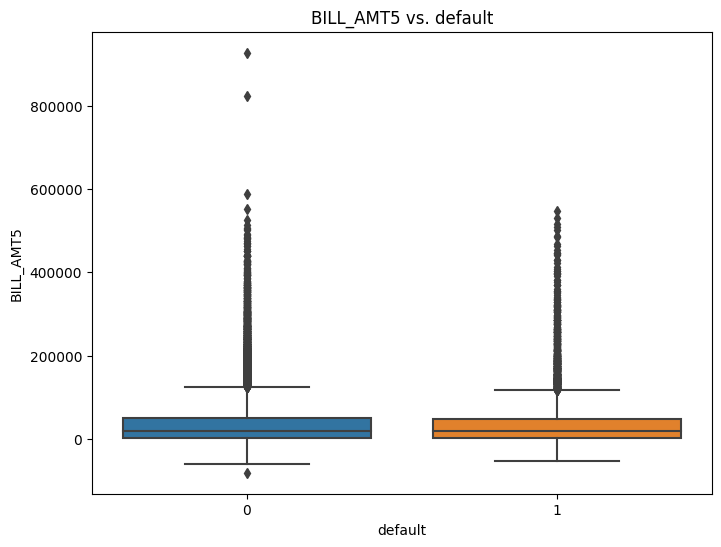

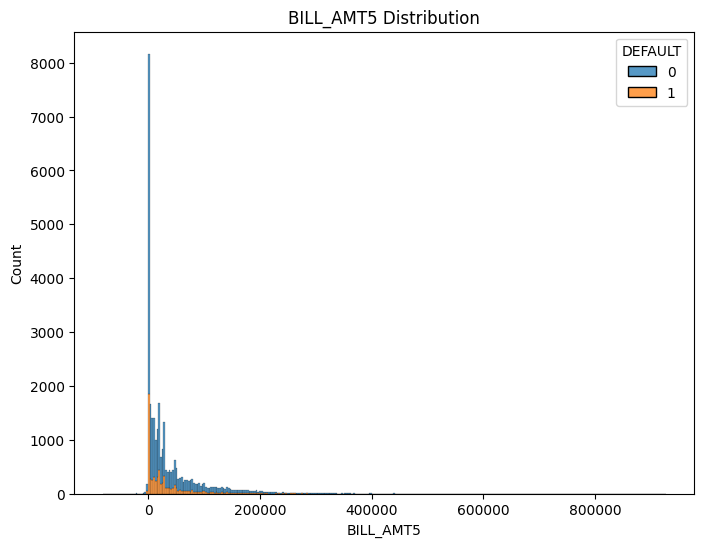

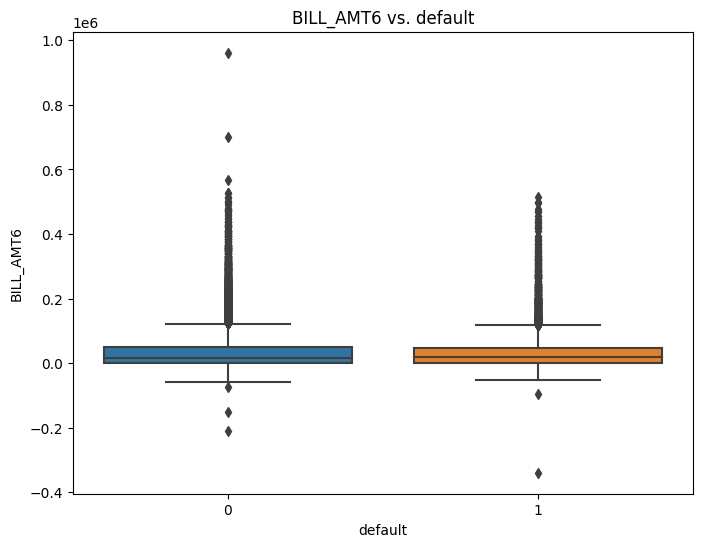

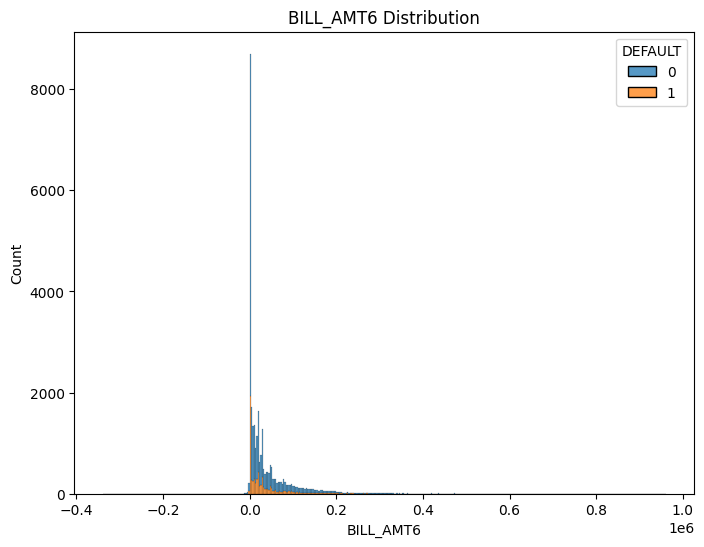

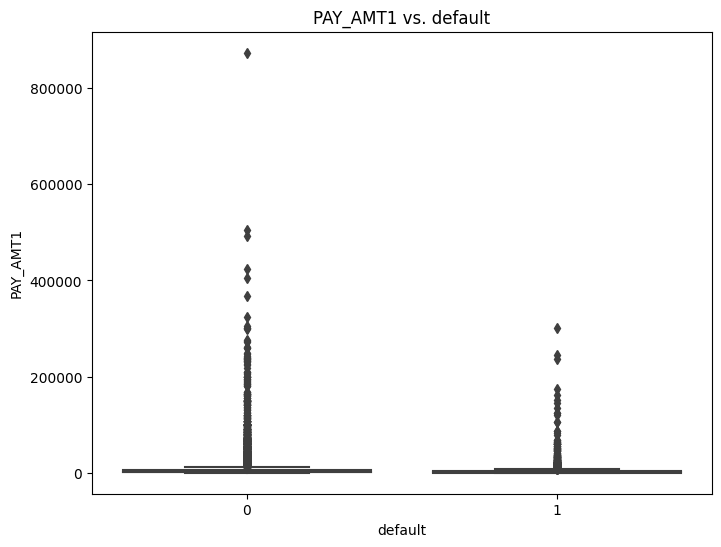

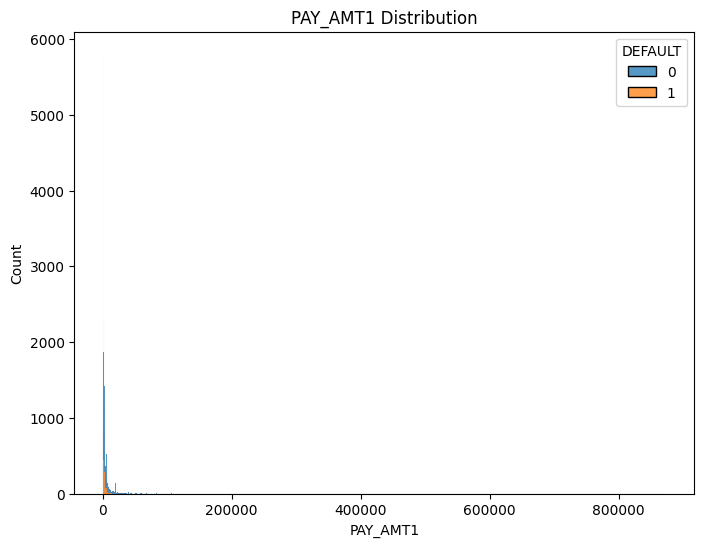

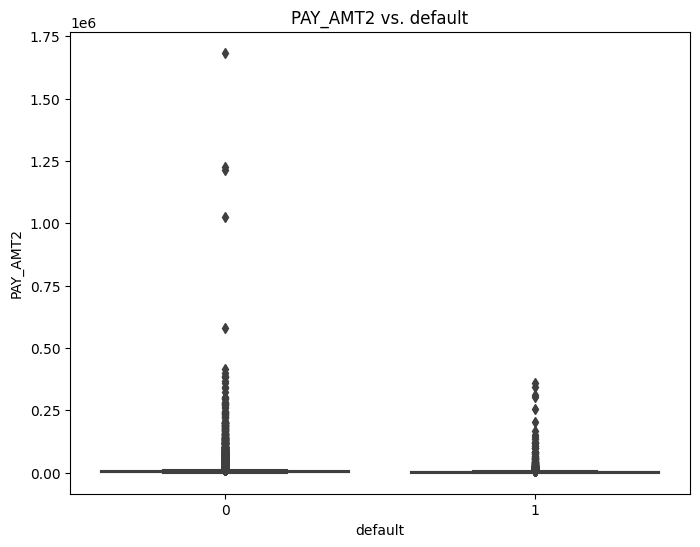

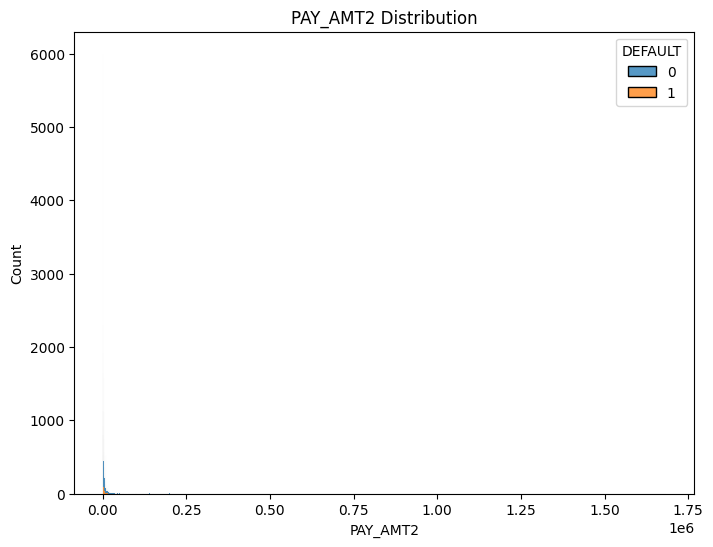

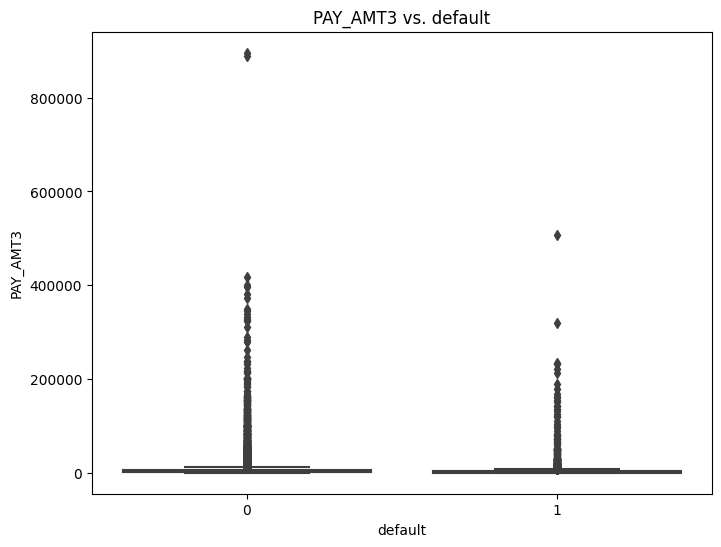

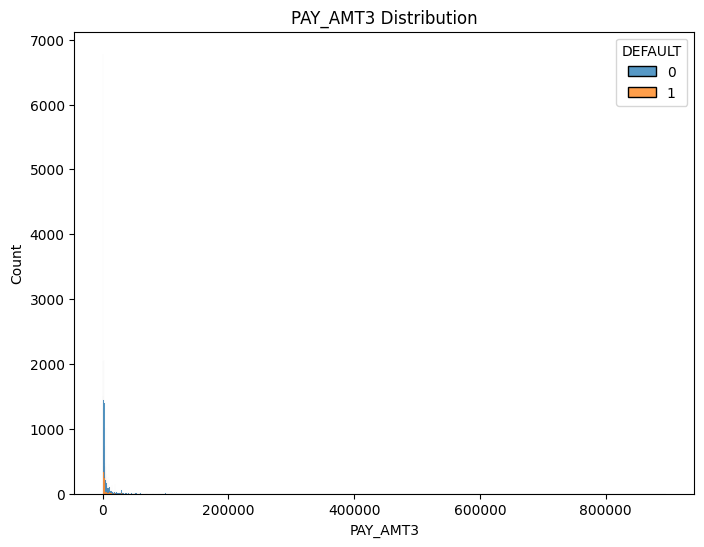

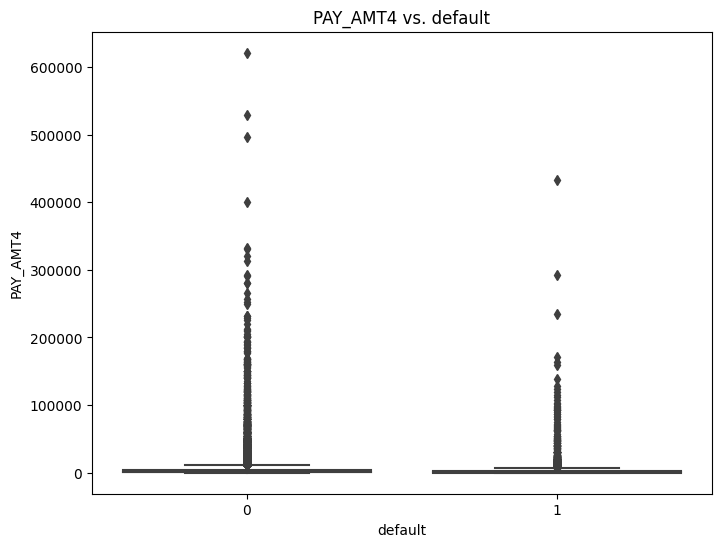

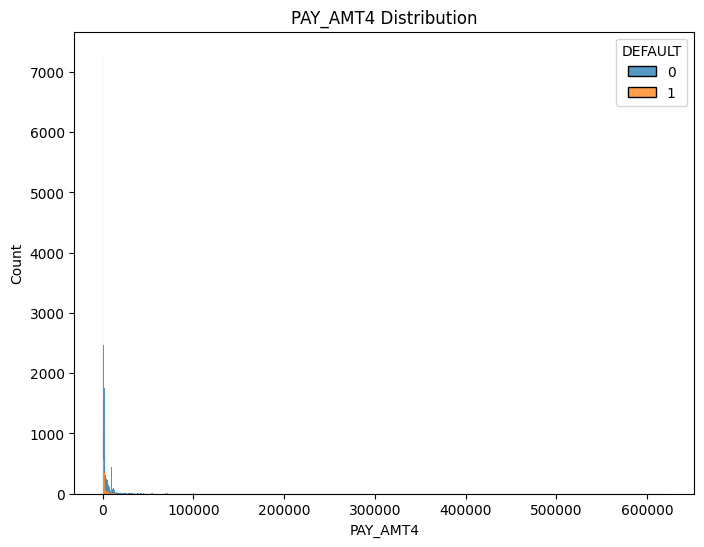

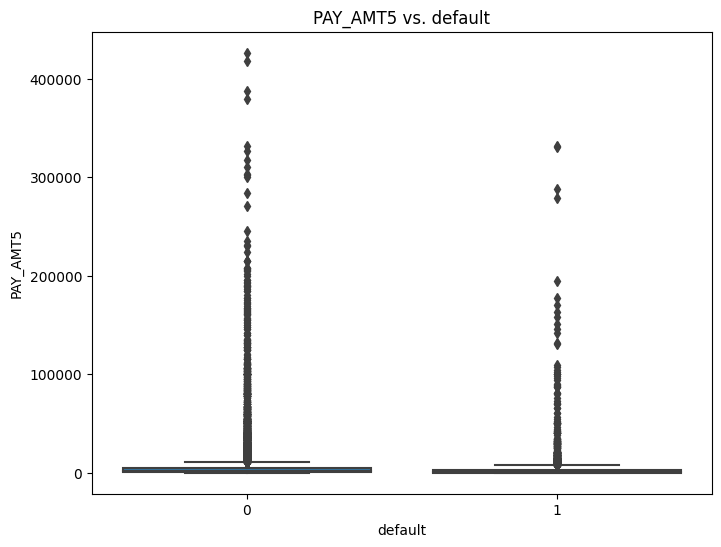

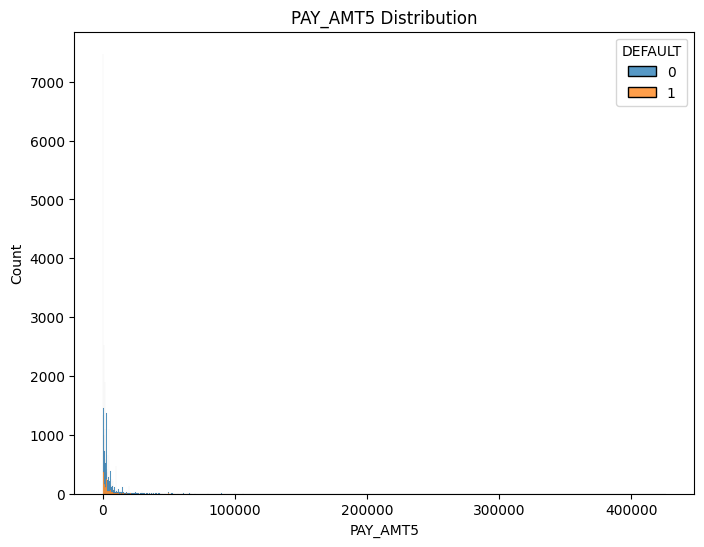

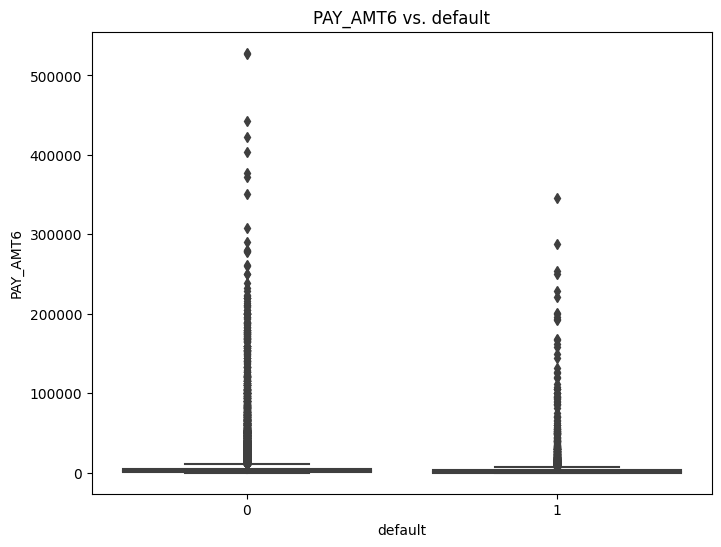

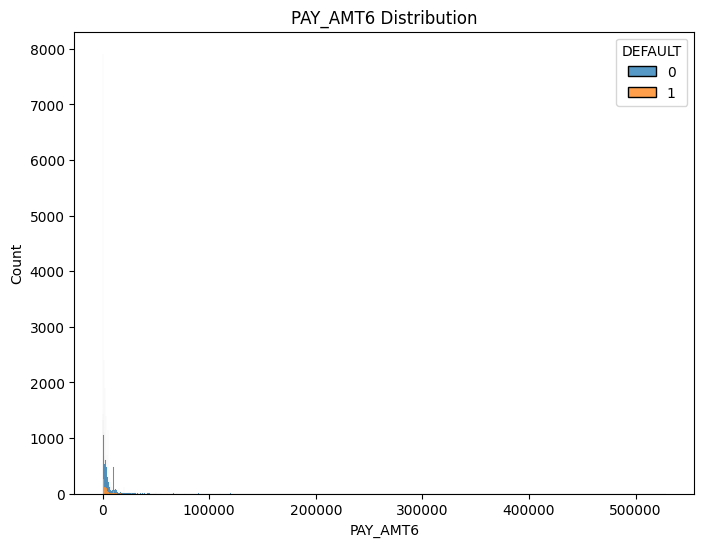

In [403]:
# Bivariate analysis for categorical attributes

for col in categorical_variables:
    cross_tab = pd.crosstab(rawdata[col], rawdata['DEFAULT'])
    cross_tab.plot(kind='bar', stacked=True)
    plt.title(f'{col} vs. default')
    plt.xlabel(col)
    plt.ylabel('Count')
    
# Add value counts of 0 and 1 on the bar graph
    for i in range(cross_tab.shape[0]):
        plt.text(i, cross_tab.iloc[i, 0] + cross_tab.iloc[i, 1], f"{cross_tab.iloc[i, 0]} / {cross_tab.iloc[i, 1]}",
                 ha='center', va='bottom')
    
    plt.show()
    

# Bivariate analysis for numeric attributes
for col in numeric_attributes:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=rawdata['DEFAULT'], y=rawdata[col])
    plt.title(f'{col} vs. default')
    plt.xlabel('default')
    plt.ylabel(col)
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.histplot(rawdata, x=col, hue='DEFAULT', multiple='stack')
    plt.title(f'{col} Distribution')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()
    


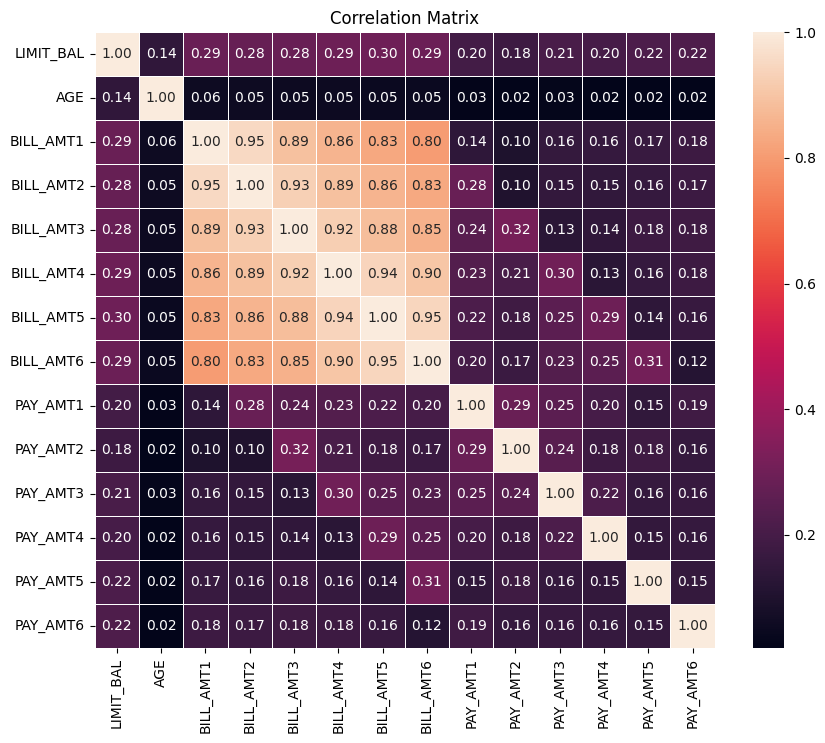

In [404]:
# Correlation matrix 
corr_matrix = rawdata[numeric_attributes].corr() #.corr is used to find corelation

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, color="k", annot=True, fmt=".2f", linewidth=0.5)
plt.title('Correlation Matrix')
plt.show()

# BILL_AMT attributes are highly correlated to each other
# Age, LIMIT_BAL and PAY_AMT attributes are less correlated

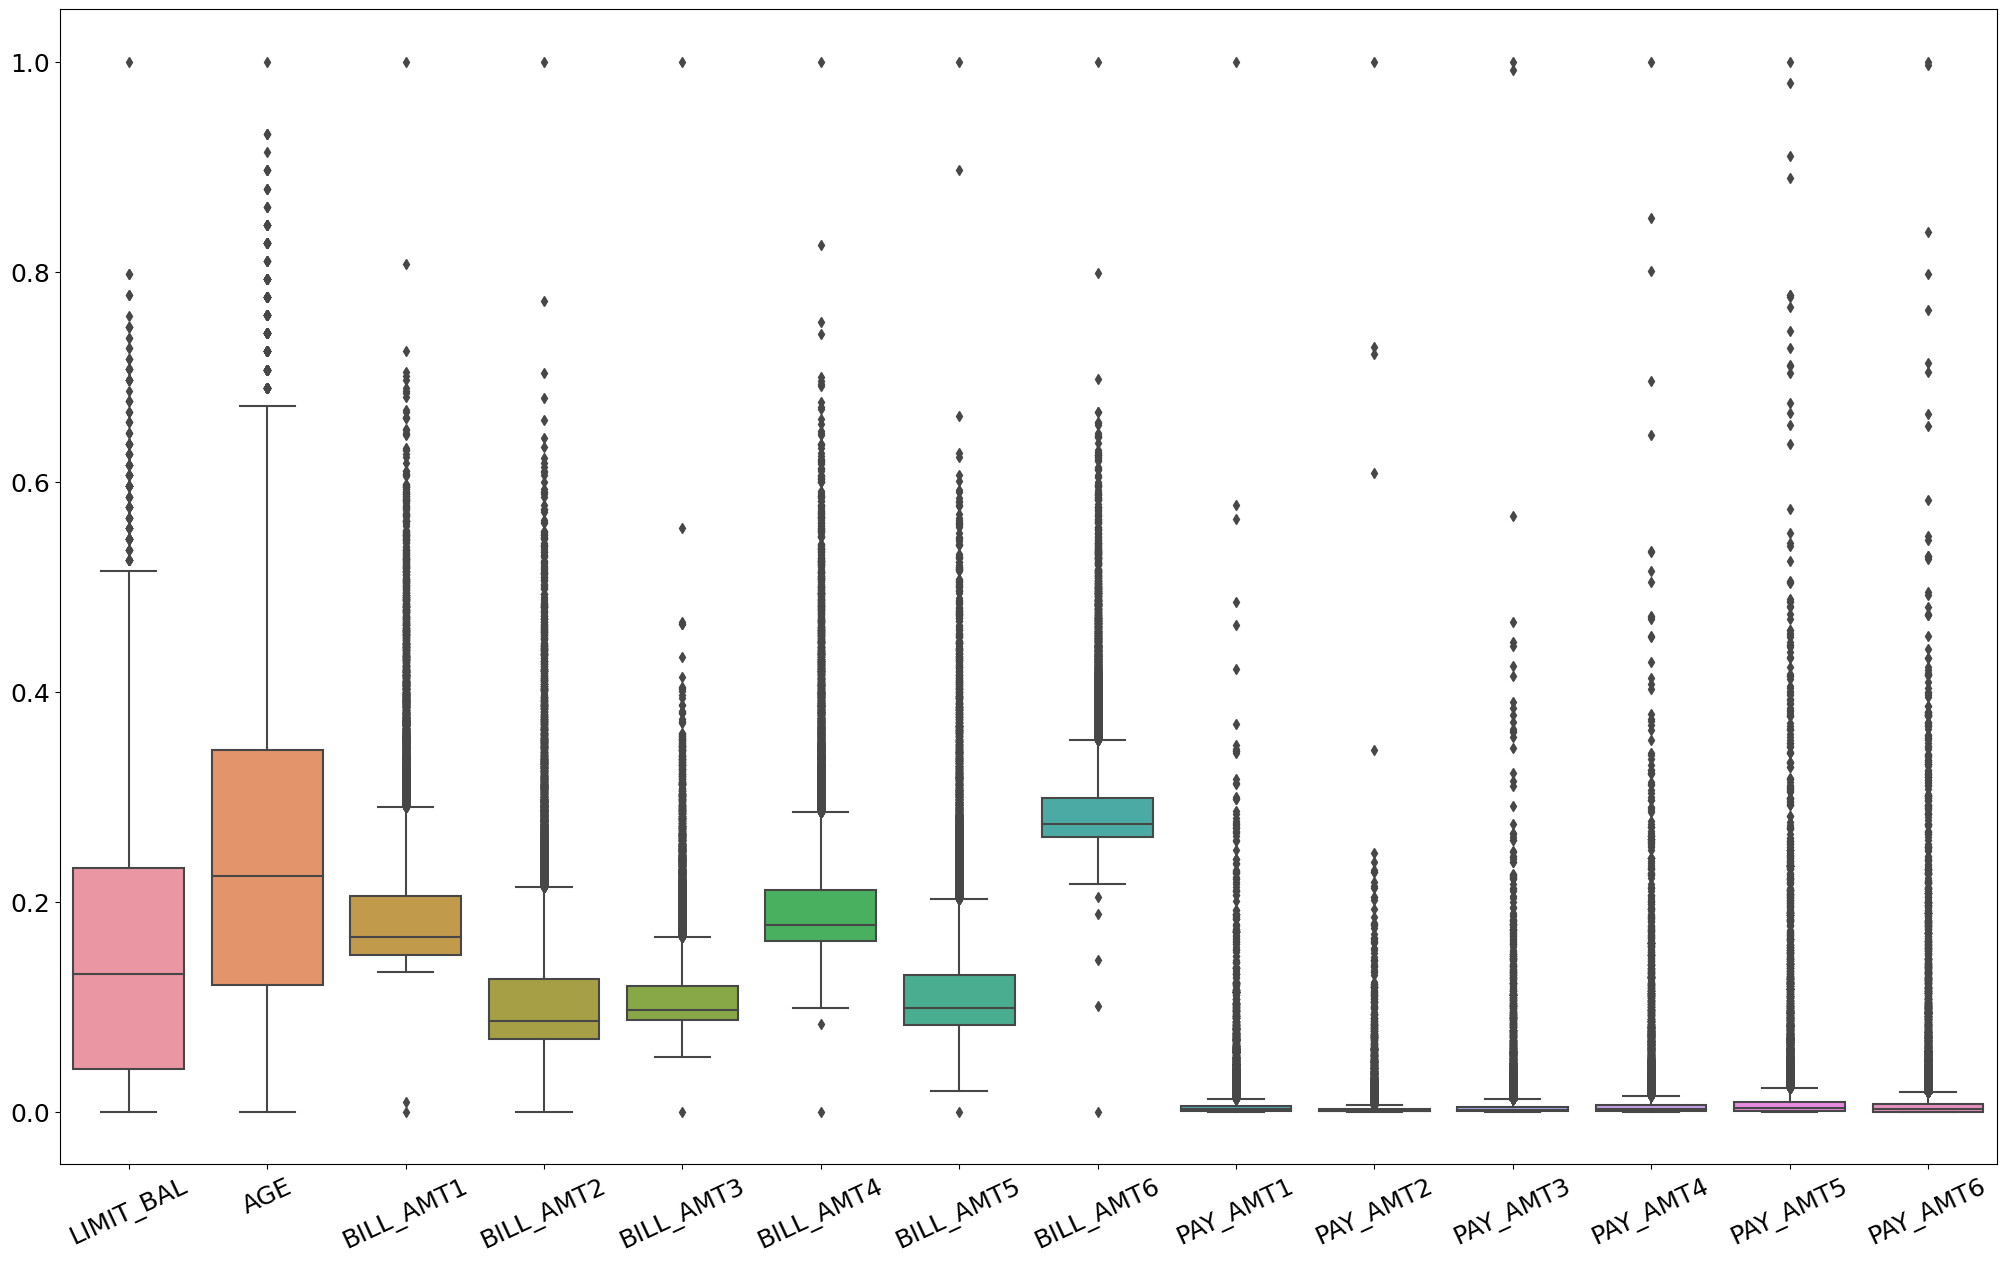

In [405]:
numeric_attributes = ['LIMIT_BAL','AGE','BILL_AMT1','BILL_AMT2','BILL_AMT3',
'BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3',
'PAY_AMT4','PAY_AMT5','PAY_AMT6']

scaler = MinMaxScaler()
rawdata['LIMIT_BAL'] = scaler.fit_transform(rawdata['LIMIT_BAL'].values.reshape(-1, 1))
rawdata['AGE'] = scaler.fit_transform(rawdata['AGE'].values.reshape(-1, 1))

for i in range(1,7):
    scaler = MinMaxScaler()
    rawdata['PAY_' + str(i)] = scaler.fit_transform(rawdata['PAY_' + str(i)].values.reshape(-1, 1))

for i in range(1,7):
    scaler = MinMaxScaler()
    rawdata['BILL_AMT' + str(i)] = scaler.fit_transform(rawdata['BILL_AMT' + str(i)].values.reshape(-1, 1))

for i in range(1,7):
    scaler = MinMaxScaler()
    rawdata['PAY_AMT' + str(i)] = scaler.fit_transform(rawdata['PAY_AMT' + str(i)].values.reshape(-1, 1))
    
# BOXPLOT

fig=plt.figure(1, figsize=(25,15))
ax=fig.add_subplot(111)
sns.boxplot(data=rawdata[numeric_attributes])
plt.xticks(np.arange(0,14), labels=numeric_attributes, rotation=25, fontsize=18)
plt.yticks(fontsize=18)
# plt.title('Boxplot', fontsize= 35)

plt.savefig('Fig - Boxplot')

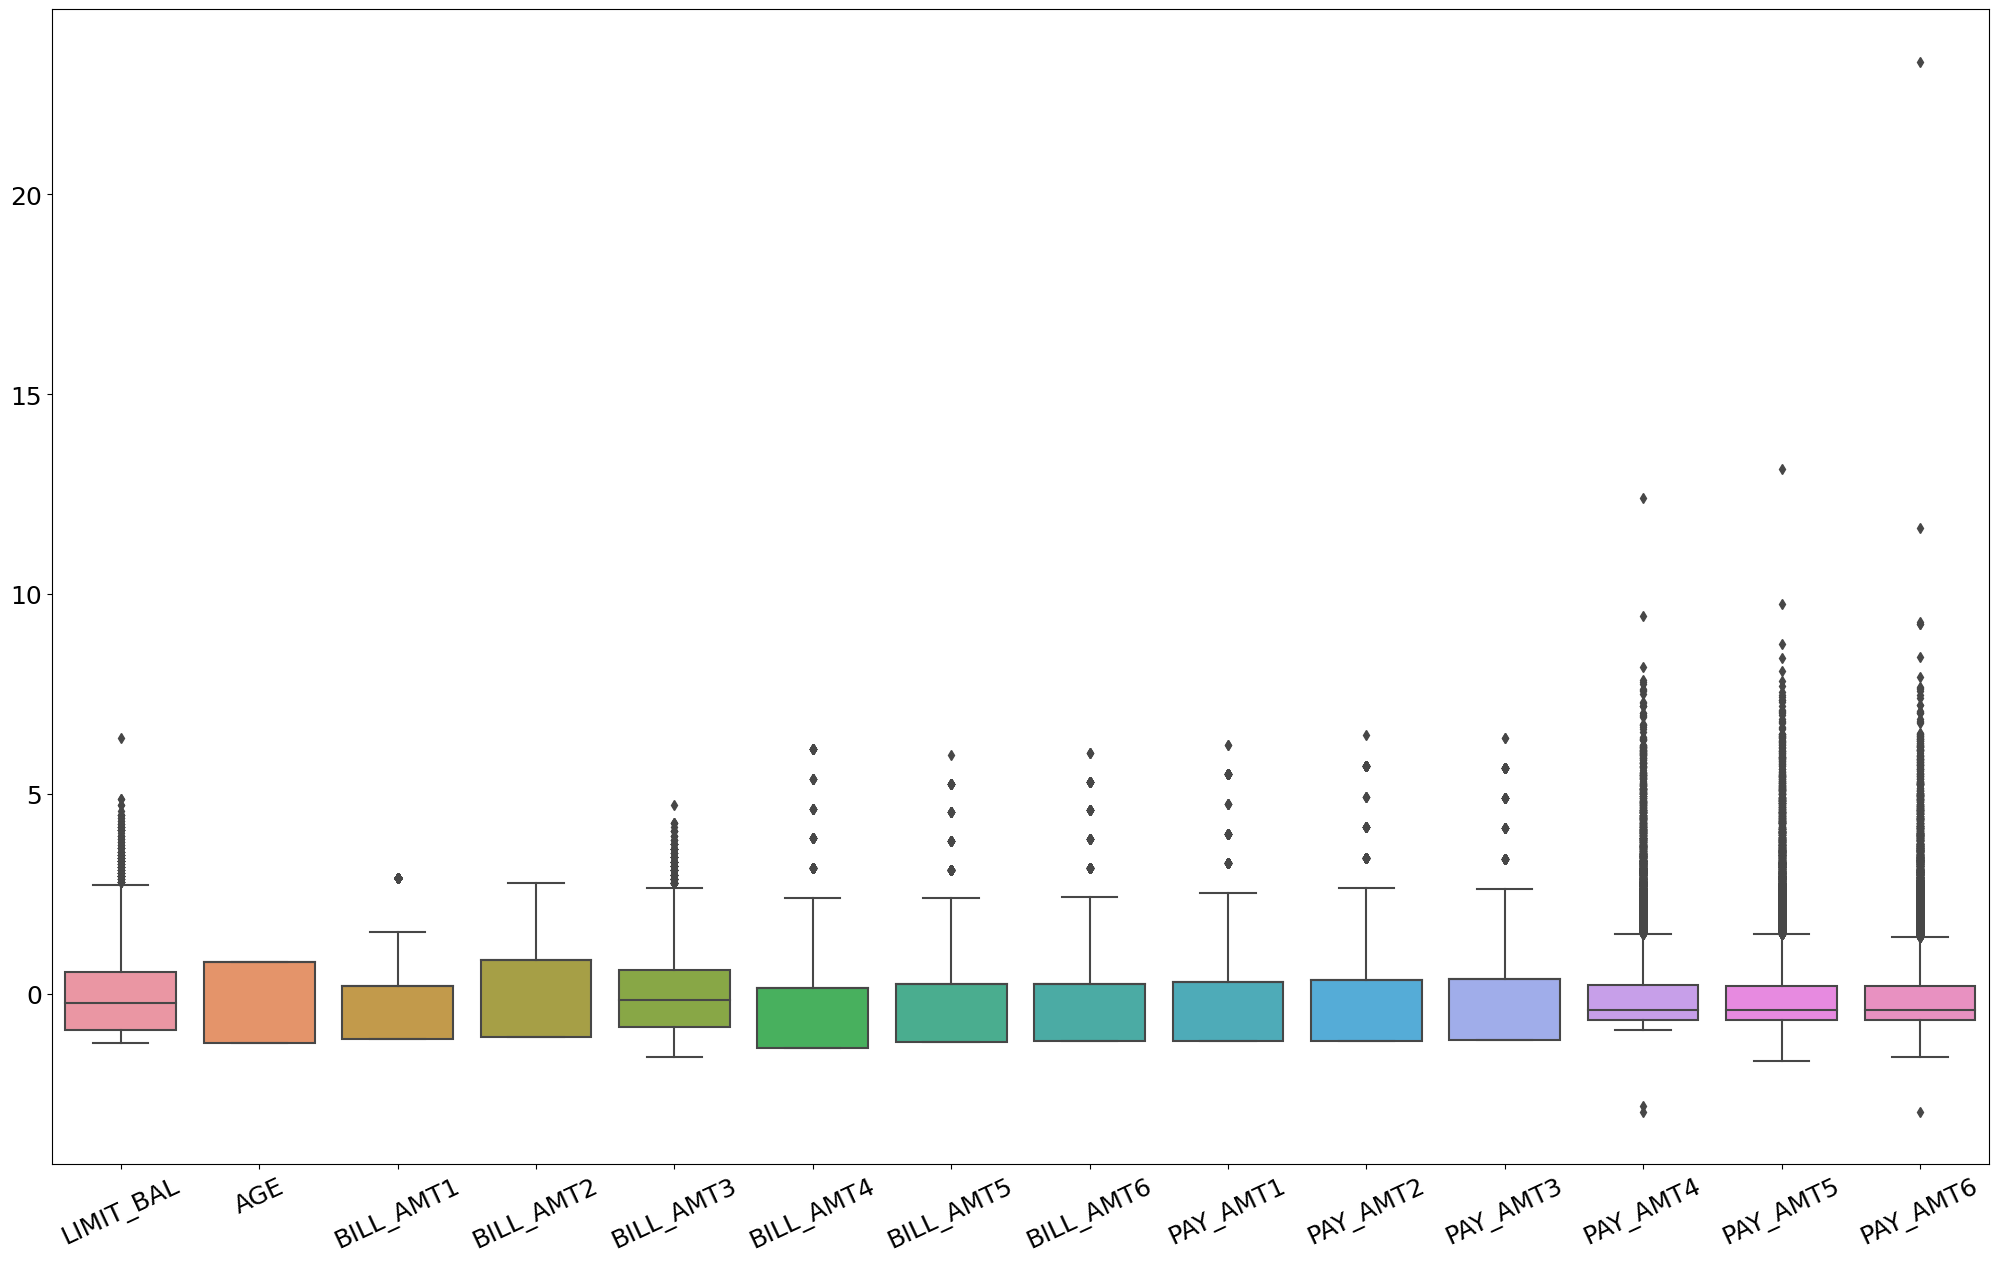

In [406]:
# Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(rawdata)

# BOXPLOT

fig=plt.figure(1, figsize=(25,15))
ax=fig.add_subplot(111)
sns.boxplot(data=scaled_data[:,:-10])
plt.xticks(np.arange(0,14), labels=numeric_attributes, rotation=25, fontsize=18)
plt.yticks(fontsize=18)
# plt.title('Boxplot', fontsize= 35)

plt.savefig('Fig - Boxplot Std Scaler')

In [407]:
# Data Pre-processing :

# One hot encoding
cat_cols = ['SEX', 'EDUCATION', 'MARRIAGE','PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
num_cols = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                      'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
default_col = ['DEFAULT']

# Apply one-hot encoding to categorical attributes
encoder = OneHotEncoder(sparse_output=False)
categorical_data = encoder.fit_transform(rawdata[cat_cols])
categorical_feature_names = encoder.get_feature_names_out(cat_cols)

# Create a DataFrame with the one-hot encoded categorical attributes
categorical_df = pd.DataFrame(categorical_data, columns=categorical_feature_names)


# Apply MinMaxScaler to the numerical attributes
#scaler = MinMaxScaler()
#scaled_numeric_data = scaler.fit_transform(X[num_cols])
numeric_df = pd.DataFrame(rawdata, columns=num_cols)

# Concatenate categorical and numerical data
rawdata = pd.concat([categorical_df, numeric_df,default_col], axis=1)

rawdata.head()

,SEX_1,SEX_2,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_1_0.0,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.160138,0.080648,0.260979,0.000000,0.000409,0.000000,0.000000,0.000000,0.000000,1
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.163220,0.084074,0.263485,0.000000,0.000594,0.001116,0.001610,0.000000,0.003783,1
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.173637,0.095470,0.272928,0.001738,0.000891,0.001116,0.001610,0.002345,0.009458,0
3,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.186809,0.109363,0.283685,0.002290,0.001199,0.001339,0.001771,0.002506,0.001892,0
4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.179863,0.099633,0.275681,0.002290,0.021779,0.011160,0.014493,0.001615,0.001284,0


Feature ranking:
1. feature 67 - AGE (0.065810) 
2. feature 66 - LIMIT_BAL (0.063352) 
3. feature 68 - BILL_AMT1 (0.052328) 
4. feature 11 - PAY_1_0.4 (0.050232) 
5. feature 69 - BILL_AMT2 (0.048430) 
6. feature 70 - BILL_AMT3 (0.047177) 
7. feature 71 - BILL_AMT4 (0.046611) 
8. feature 73 - BILL_AMT6 (0.046406) 
9. feature 79 - PAY_AMT6 (0.046204) 
10. feature 72 - BILL_AMT5 (0.045723) 
11. feature 78 - PAY_AMT5 (0.044154) 
12. feature 74 - PAY_AMT1 (0.043862) 
13. feature 75 - PAY_AMT2 (0.043020) 
14. feature 76 - PAY_AMT3 (0.042679) 
15. feature 77 - PAY_AMT4 (0.042251) 
16. feature 21 - PAY_2_0.4 (0.024246) 
17. feature 9 - PAY_1_0.2 (0.021231) 
18. feature 31 - PAY_3_0.4 (0.018438) 
19. feature 0 - SEX_2 (0.016582) 
20. feature 50 - PAY_5_0.4 (0.013843) 
21. feature 41 - PAY_4_0.4 (0.012547) 
22. feature 8 - PAY_1_0.0 (0.011999) 
23. feature 2 - EDUCATION_2 (0.009819) 
24. feature 10 - PAY_1_0.30000000000000004 (0.009334) 
25. feature 59 - PAY_6_0.4 (0.009327) 
26. feature 18 - PA

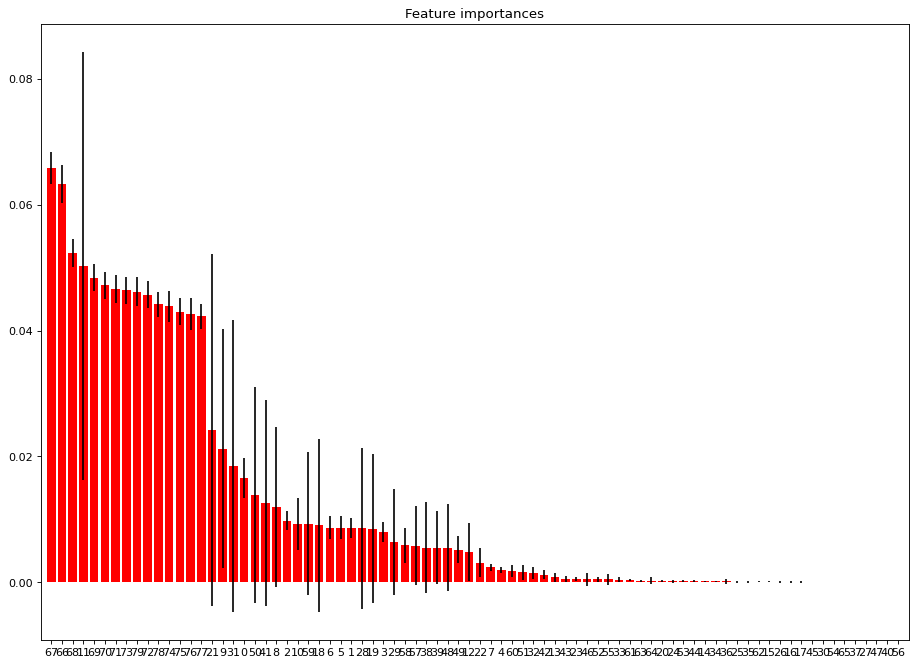

In [408]:
# Build a classification task using 3 informative features
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

features=list(rawdata.columns[1:-1])
X=rawdata[features]
y = rawdata['DEFAULT']
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d - %s (%f) " % (f + 1, indices[f], features[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(num=None, figsize=(14, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [409]:
for f in range(5):
    print("%d. feature %d - %s (%f)" % (f + 1, indices[f], features[indices[f]] ,importances[indices[f]]))
    
best_features = []
for i in indices[:5]:
    best_features.append(features[i])

1. feature 67 - AGE (0.065810)
2. feature 66 - LIMIT_BAL (0.063352)
3. feature 68 - BILL_AMT1 (0.052328)
4. feature 11 - PAY_1_0.4 (0.050232)
5. feature 69 - BILL_AMT2 (0.048430)


Fold 1 - DecisionTreeClassifier() :
Training set accuracy: 0.9933333333333333
Validation set accuracy: 0.7048333333333333
Training set precision: 0.9950143815915627
Validation set precision: 0.33260233918128657
Training set recall: 0.9748262258125118
Validation set recall: 0.3465346534653465
Training set F1 score: 0.9848168532928449
Validation set F1 score: 0.3394255874673629
Training set Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     18677
           1       1.00      0.97      0.98      5323

    accuracy                           0.99     24000
   macro avg       0.99      0.99      0.99     24000
weighted avg       0.99      0.99      0.99     24000

Validation set Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.81      0.81      4687
           1       0.33      0.35      0.34      1313

    accuracy                           0.70      6000


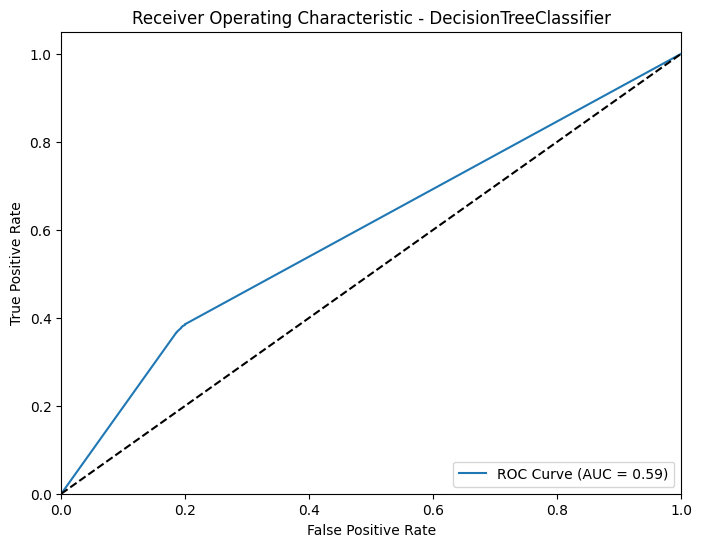

Fold 1 - LogisticRegression() :
Training set accuracy: 0.811375
Validation set accuracy: 0.8146666666666667
Training set precision: 0.6902485659655831
Validation set precision: 0.6943907156673114
Training set recall: 0.2712755964681571
Validation set recall: 0.27341964965727344
Training set F1 score: 0.38948078219824683
Validation set F1 score: 0.39234972677595625
Training set Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.97      0.89     18677
           1       0.69      0.27      0.39      5323

    accuracy                           0.81     24000
   macro avg       0.76      0.62      0.64     24000
weighted avg       0.79      0.81      0.78     24000

Validation set Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.97      0.89      4687
           1       0.69      0.27      0.39      1313

    accuracy                           0.81      6000
   macro avg

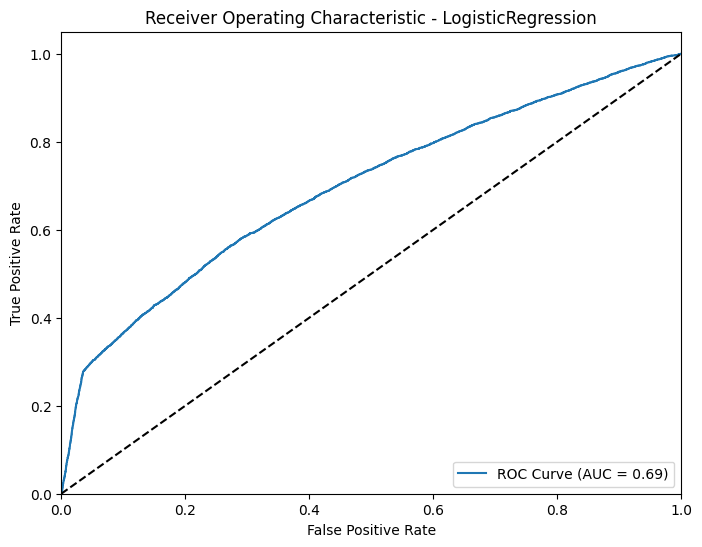

Fold 1 - RandomForestClassifier() :
Training set accuracy: 0.9933333333333333
Validation set accuracy: 0.7943333333333333
Training set precision: 0.9910595396614038
Validation set precision: 0.5557122708039492
Training set recall: 0.9787713695284614
Validation set recall: 0.3000761614623001
Training set F1 score: 0.9848771266540643
Validation set F1 score: 0.3897131552917903
Training set Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     18677
           1       0.99      0.98      0.98      5323

    accuracy                           0.99     24000
   macro avg       0.99      0.99      0.99     24000
weighted avg       0.99      0.99      0.99     24000

Validation set Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.93      0.88      4687
           1       0.56      0.30      0.39      1313

    accuracy                           0.79      6000
 

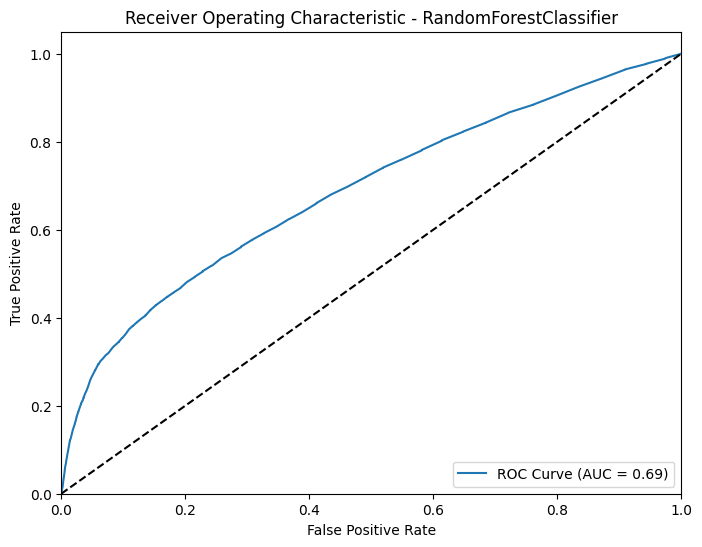

In [410]:
# Train and validation using best features
# K-fold Cross Validation

best_features = ['LIMIT_BAL','AGE','BILL_AMT1','BILL_AMT2','PAY_1_0.4']

X_best = rawdata[best_features]
y = rawdata['DEFAULT']

# Initialize the models
models1 = [
    DecisionTreeClassifier(),
    LogisticRegression(),
    RandomForestClassifier()
]

# Perform 5-fold cross-validation for each model
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for model in models1:
    # Initialize lists to store true labels and predicted probabilities
    true_labels = []
    pred_probabilities = []
    accuracy_train_scores = []
    accuracy_val_scores = []
    precision_train_scores = []
    precision_val_scores = []
    recall_train_scores = []
    recall_val_scores = []
    f1_train_scores = []
    f1_val_scores = []
    new_line = '\n'
    
    # Iterate over each fold
    for fold, (train_index, test_index) in enumerate(kf.split(X_best)):
        X_train, X_val = X_best.iloc[train_index], X_best.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]

        # Train the model
        model.fit(X_train, y_train)

        # Predict probabilities for class 1
        y_pred_proba = model.predict_proba(X_val)[:, 1]

        # Append true labels and predicted probabilities
        true_labels.extend(y_val)
        pred_probabilities.extend(y_pred_proba)
        
        # Evaluate the models on the training set
        train_score = model.score(X_train, y_train)
        accuracy_train_scores.append(train_score)
        y_train_pred = model.predict(X_train)
        precision_train = precision_score(y_train, y_train_pred,zero_division=1.0)
        recall_train = recall_score(y_train, y_train_pred,zero_division=1.0)
        f1_train = f1_score(y_train, y_train_pred,zero_division=1.0)
        precision_train_scores.append(precision_train)
        recall_train_scores.append(recall_train)
        f1_train_scores.append(f1_train)
        train_report = classification_report(y_train, y_train_pred,zero_division=1.0)
        
        # Evaluate the models on the validation set
        val_score = model.score(X_val, y_val)
        accuracy_val_scores.append((val_score))
        y_val_pred = model.predict(X_val)
        precision_val = precision_score(y_val, y_val_pred,zero_division=1.0)
        recall_val = recall_score(y_val, y_val_pred,zero_division=1.0)
        f1_val = f1_score(y_val, y_val_pred,zero_division=1.0)
        precision_val_scores.append(precision_val)
        recall_val_scores.append(recall_val)
        f1_val_scores.append(f1_val)
        val_report = classification_report(y_val, y_val_pred,zero_division=1.0)
        
        # Print the accuracy scores for each fold
        print(f"Fold {fold+1} - {model} :")
        print(f"Training set accuracy: {train_score}")
        print(f"Validation set accuracy: {val_score}")
        print(f"Training set precision: {precision_train}")
        print(f"Validation set precision: {precision_val}")
        print(f"Training set recall: {recall_train}")
        print(f"Validation set recall: {recall_val}")
        print(f"Training set F1 score: {f1_train}")
        print(f"Validation set F1 score: {f1_val}")  
        print(f"Training set Classification Report:{new_line} {train_report}")
        print(f"Validation set Classification Report:{new_line} {val_report}")

    # Calculate false positive rate, true positive rate, and thresholds
    fpr, tpr, thresholds = roc_curve(true_labels, pred_probabilities)

    # Calculate AUC-ROC score
    auc_roc_score = auc(fpr, tpr)
    print(f"Model: {type(model).__name__}")
    print(f"AUC-ROC Score: {auc_roc_score}")

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % auc_roc_score)
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {type(model).__name__}')
    plt.legend(loc="lower right")
    plt.show()

DecisionTreeClassifier():
Test Size: 0.2
Training set accuracy: 0.9930416666666667
Test set accuracy: 0.6988333333333333
Training set precision: 0.9949670925280681
Test set precision: 0.34392265193370164
Training set recall: 0.9733005112668055
Test set recall: 0.3675276752767528
Training set F1 score: 0.9840145496314732
Test set F1 score: 0.3553335711737424
Training set Classification Report:
                precision    recall  f1-score   support

           0       0.99      1.00      1.00     18719
           1       0.99      0.97      0.98      5281

    accuracy                           0.99     24000
   macro avg       0.99      0.99      0.99     24000
weighted avg       0.99      0.99      0.99     24000

Test set Classification Report:
                precision    recall  f1-score   support

           0       0.81      0.80      0.80      4645
           1       0.34      0.37      0.36      1355

    accuracy                           0.70      6000
   macro avg       0.58

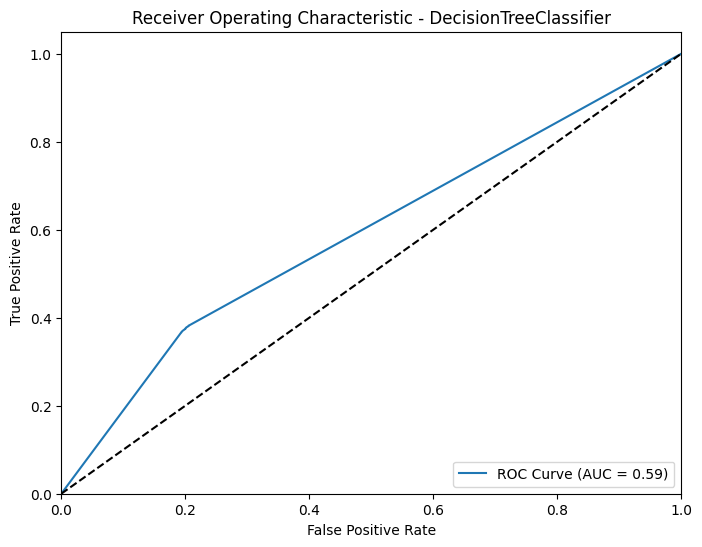

LogisticRegression():
Test Size: 0.2
Training set accuracy: 0.8134583333333333
Test set accuracy: 0.8075
Training set precision: 0.6914285714285714
Test set precision: 0.6915708812260536
Training set recall: 0.27494792652906647
Test set recall: 0.26642066420664207
Training set F1 score: 0.39344262295081966
Test set F1 score: 0.3846563665423548
Training set Classification Report:
                precision    recall  f1-score   support

           0       0.83      0.97      0.89     18719
           1       0.69      0.27      0.39      5281

    accuracy                           0.81     24000
   macro avg       0.76      0.62      0.64     24000
weighted avg       0.80      0.81      0.78     24000

Test set Classification Report:
                precision    recall  f1-score   support

           0       0.82      0.97      0.89      4645
           1       0.69      0.27      0.38      1355

    accuracy                           0.81      6000
   macro avg       0.76      0.62    

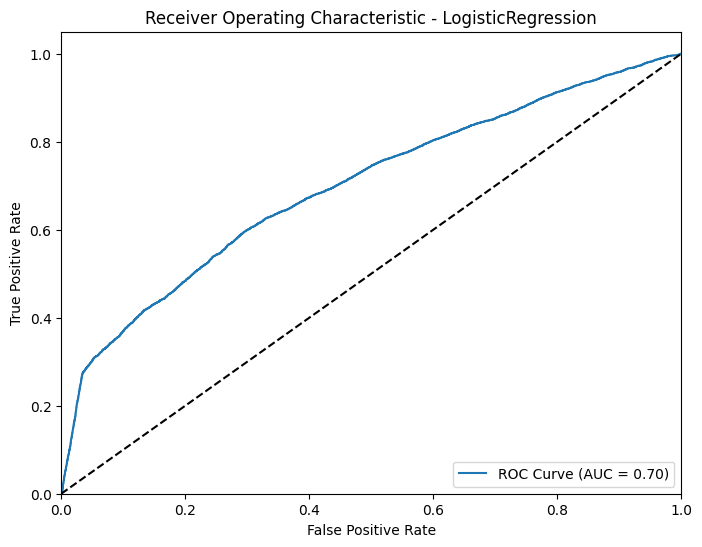

RandomForestClassifier():
Test Size: 0.2
Training set accuracy: 0.9929583333333334
Test set accuracy: 0.7896666666666666
Training set precision: 0.990595009596929
Test set precision: 0.5674891146589259
Training set recall: 0.9772770308653664
Test set recall: 0.28856088560885607
Training set F1 score: 0.9838909541511772
Test set F1 score: 0.38258317025440314
Training set Classification Report:
                precision    recall  f1-score   support

           0       0.99      1.00      1.00     18719
           1       0.99      0.98      0.98      5281

    accuracy                           0.99     24000
   macro avg       0.99      0.99      0.99     24000
weighted avg       0.99      0.99      0.99     24000

Test set Classification Report:
                precision    recall  f1-score   support

           0       0.82      0.94      0.87      4645
           1       0.57      0.29      0.38      1355

    accuracy                           0.79      6000
   macro avg       0.69

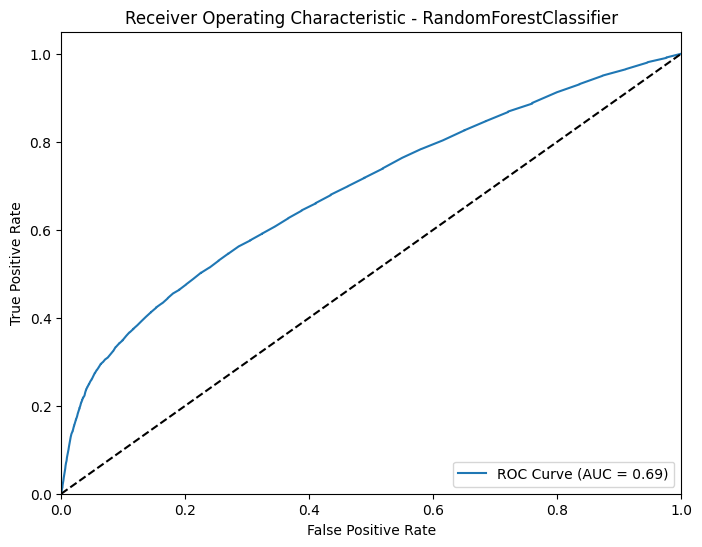

In [412]:
# Train and validation using best features
# Train-Test Split

best_features = ['LIMIT_BAL','AGE','BILL_AMT1','BILL_AMT2','PAY_1_0.4']

X_best = rawdata[best_features]
y = rawdata['DEFAULT']

# Initialize the models
models2 = [
    DecisionTreeClassifier(),
    LogisticRegression(),
    RandomForestClassifier()
]

# Different test sizes for train-test split
test_sizes = [0.2, 0.3, 0.4]  

for model in models2:

    # Initialize lists to store true labels and predicted probabilities
    # define lists to collect scores
    train_scores1, test_scores1 = list(), list()
    new_line = '\n'
    true_labels1 = []
    pred_probabilities1 = []
    accuracy_train_scores1 = []
    accuracy_test_scores1 = []
    precision_train_scores1 = []
    precision_test_scores1 = []
    recall_train_scores1 = []
    recall_test_scores1 = []
    f1_train_scores1 = []
    f1_test_scores1 = []
    
    # Iterate over different test sizes
    for test_size in test_sizes: 
        # Split the data into train and test sets
        X_train1, X_test1, y_train1, y_test1 = train_test_split(X_best, y, test_size=test_size, random_state=67)
        # Fit the classifier on the training data
        model.fit(X_train1, y_train1)    
        # Predict probabilities for class 1
        y_pred_proba = model.predict_proba(X_test1)[:, 1]

        # Append true labels and predicted probabilities
        true_labels1.extend(y_test1)
        pred_probabilities1.extend(y_pred_proba)

        # evaluate on the train dataset
        y_train_pred1 = model.predict(X_train1)
        accuracy_train_scores1 = accuracy_score(y_train1, y_train_pred1)
        train_scores1.append(accuracy_train_scores1)
        precision_train1 = precision_score(y_train1, y_train_pred1,zero_division=1.0)
        recall_train1 = recall_score(y_train1, y_train_pred1,zero_division=1.0)
        f1_train1 = f1_score(y_train1, y_train_pred1,zero_division=1.0)
        precision_train_scores1.append(precision_train1)
        recall_train_scores1.append(recall_train1)
        f1_train_scores1.append(f1_train1)
        # Generate the classification report
        train_report1 = classification_report(y_train1, y_train_pred1, zero_division=1.0)
        
        # evaluate on the test dataset
        y_test_pred1 = model.predict(X_test1)
        accuracy_test_scores1 = accuracy_score(y_test1, y_test_pred1)
        test_scores1.append(test_acc1)
        precision_test1 = precision_score(y_test1, y_test_pred1,zero_division=1.0)
        recall_test1 = recall_score(y_test1, y_test_pred1,zero_division=1.0)
        f1_test1 = f1_score(y_test1, y_test_pred1,zero_division=1.0)
        precision_test_scores1.append(precision_test1)
        recall_test_scores1.append(recall_test1)
        f1_test_scores1.append(f1_test1)
        # Generate the classification report
        test_report1 = classification_report(y_test1, y_test_pred1,zero_division=1.0)
    
        print(f"{model}:")
        print(f"Test Size: {test_size}")
        print(f"Training set accuracy: {accuracy_train_scores1}")
        print(f"Test set accuracy: {accuracy_test_scores1}")
        print(f"Training set precision: {precision_train1}")
        print(f"Test set precision: {precision_test1}")
        print(f"Training set recall: {recall_train1}")
        print(f"Test set recall: {recall_test1}")
        print(f"Training set F1 score: {f1_train1}")
        print(f"Test set F1 score: {f1_test1}")  
        print(f"Training set Classification Report:{new_line}  {train_report1}")
        print(f"Test set Classification Report:{new_line}  {test_report1}")
    
    # Calculate false positive rate, true positive rate, and thresholds
    fpr, tpr, thresholds = roc_curve(true_labels1, pred_probabilities1)

    # Calculate AUC-ROC score
    auc_roc_score = auc(fpr, tpr)
    print(f"Model: {type(model).__name__}")
    print(f"AUC-ROC Score: {auc_roc_score}")

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % auc_roc_score)
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {type(model).__name__}')
    plt.legend(loc="lower right")
    plt.show()